In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pymc3

import calibr8
import cutisplit
import retl
import robotools

import run_analysis


print(f"pymc {pymc3.__version__}")
print(f"calibr8 {calibr8.__version__}")

pymc 3.11.2
calibr8 6.0.2


In [37]:
DCS_EXPERIMENT = 'Pahpshmir_MTP-Screening-PETase'
RUN_ID = "BZACW9"
analyser = run_analysis.CutisplitAnalysis(DCS_EXPERIMENT, RUN_ID)
resultpath = f'{RUN_ID}_Results' 
if not os.path.isdir(resultpath):
    os.makedirs(resultpath)

## Model inputs
The model reproduces the experimental layout and dilutions of samples/standards that go into the assays.
This layout should be given in a `DataFrame`, indexed by the `input_well` ID (the DWP well) and having columns `"type"` and `"concentration_factor"`.

The `"type"` should represent the kind of sample.
`"concentration_factor"` allows you to analyze different dilutions at the same time.

In [38]:
df_inputs = analyser.get_df_inputs().dropna()
df_inputs.head()

type concentration_factor
input_well                           
B01         NprE                    1
B02         YpjP                    1
B03          Mpr                    1
B04         YwaD                    1
B05         SacC                    1

We'll need at least one dataset - Cutinase, split-GFP or both.
The cutinase dataset should be represented as a DataFrame:

In [39]:
df_cutinase = analyser.get_df_cutinase()
df_cutinase.head()

FileNotFoundError: [Errno 2] No such file or directory: '\\\\IBT705\\DATA\\CM\\Pahpshmir_MTP-Screening-PETase\\BZACW9\\Cutinase_Sample.xml'

To translate between absorbance readings and product concentration, the model needs a `calibr8` calibration model for p-Nitrophenol absorbance/concentration.

In [40]:
df_calibration = analyser.get_df_calibration(repetition=1)
df_calibration

concentration  absorbance
H12       0.000017      0.3469
H10       0.000017      0.4153
G12       0.000017      0.3629
G11       0.000017      0.3889
G10       0.000017      0.4165
..             ...         ...
D11       0.416667         NaN
D10       0.416667         NaN
E12       0.433333         NaN
E10       0.433333         NaN
E11       0.433333         NaN

[72 rows x 2 columns]

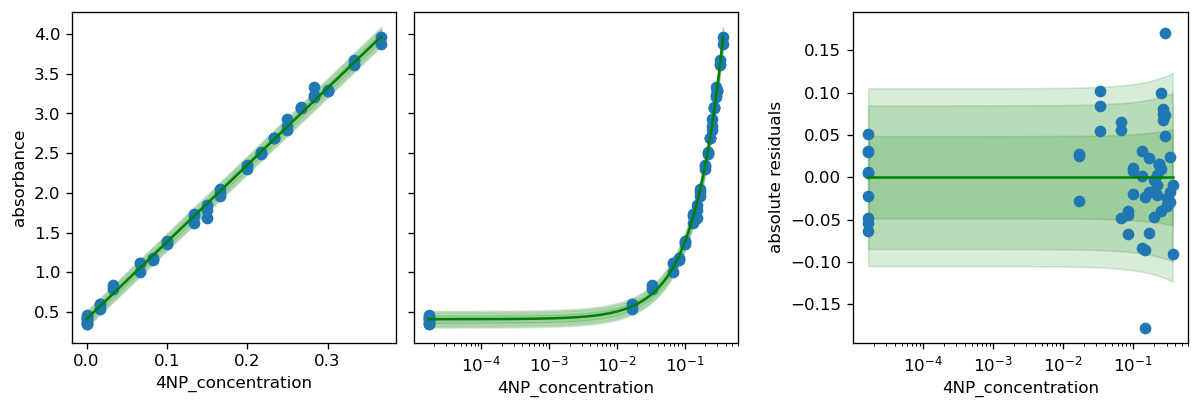

In [41]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel()
theta_fit, _ = calibr8.fit_scipy(
    model=cm_nitrophenol,
    independent=df_calibration.dropna().concentration.values,
    dependent=df_calibration.dropna().absorbance.values,
    theta_guess=[0.5, 2, 0.1, 0.1, 30],
    theta_bounds=[
        (0.001, 50)
    ] * len(cm_nitrophenol.theta_names)
)
cm_nitrophenol.save(fr"{resultpath}\{RUN_ID}_cm_nitrophenol.json")

fig, axs = calibr8.plot_model(cm_nitrophenol)
pyplot.show()

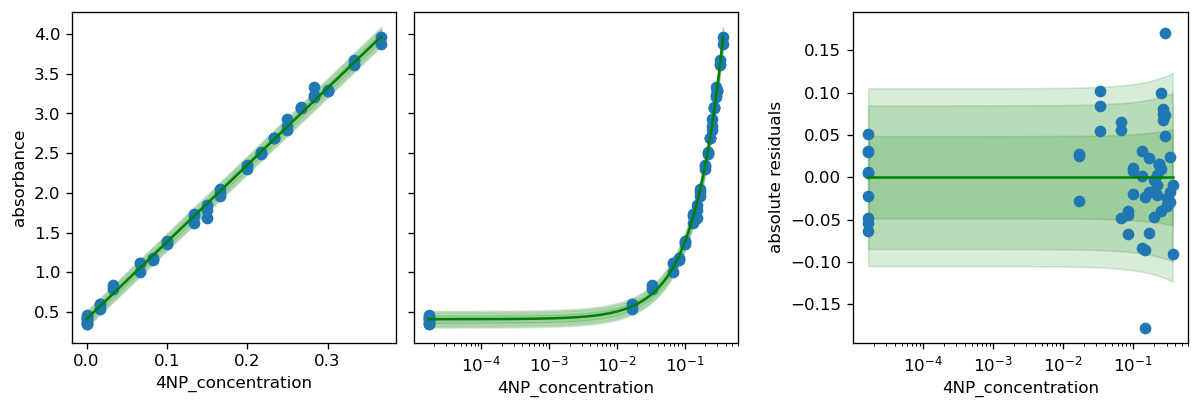

In [42]:
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol);

## Creating the Model
The model is initialized from the `df_inputs` that explains the structure of the dataset, plus the observations from cutinase assay, split-GFP assay or both.

In [43]:
model = cutisplit.CombinedModel(
    df_inputs,
    df_cutinase=df_cutinase,
    cm_nitrophenol=cm_nitrophenol,
    df_sgfp=None,
    sd_sgfp=1
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

ValueError: Input dimension mis-match. (input[0].shape[1] = 30, input[1].shape[1] = 48)

The PyMC3 model can be visualized as a graph:

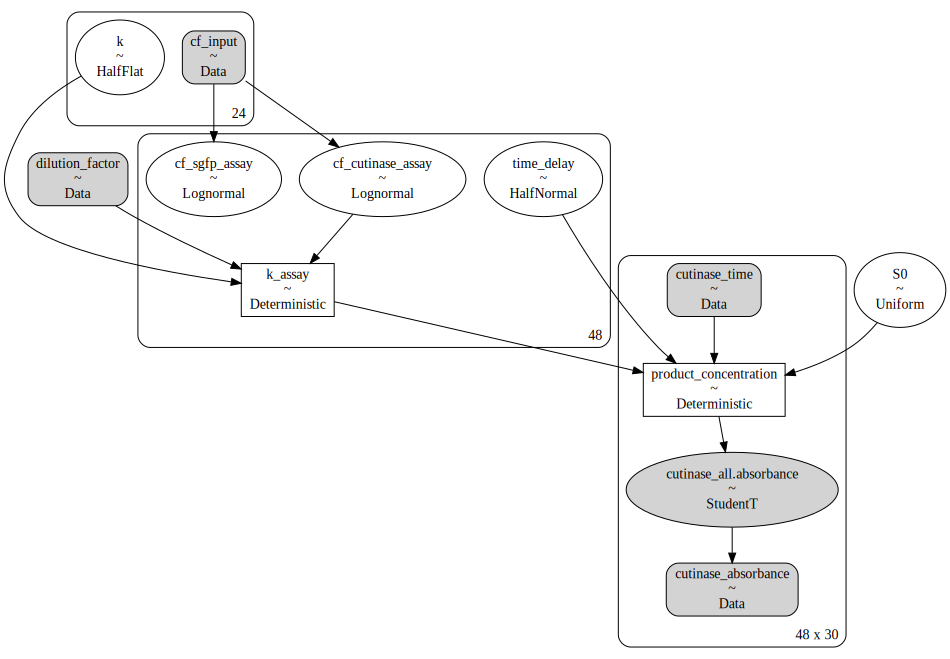

In [44]:
pymc3.model_to_graphviz(model.pmodel)

In [45]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [time_delay, S0, k, cf_sgfp_assay, cf_cutinase_assay]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 165 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [29]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_exponential.nc") 

PermissionError: [Errno 13] Permission denied: b'C:\\Users\\helleckes\\Repos\\cutisplit\\notebooks\\BZACW9_Results\\BZACW9_result_exponential.nc'

Execute the next cell in case you want to reload saved data

In [ ]:
idata = arviz.from_netcdf(fr"{resultpath}\{RUN_ID}_result_exponential.nc")
idata

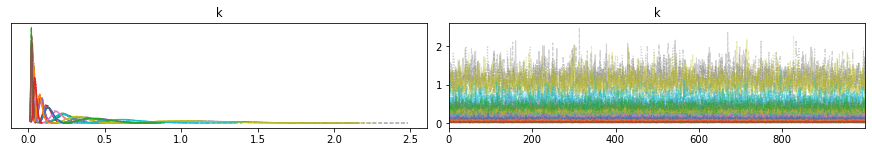

In [46]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=["k"]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

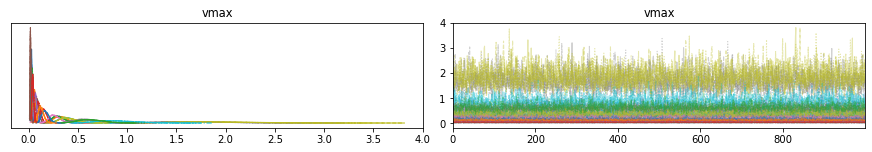

In [14]:
# For every "type" there is a vmax and fmax result:
arviz.plot_trace(idata, var_names=["vmax"]);
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

In [31]:
# local vars to make code more readable:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (assay_well: 48, sample: 4000, type: 24, cutinase_cycle: 30)
Coordinates:
  * assay_well             (assay_well) <U3 'B01' 'B02' 'B03' ... 'G11' 'G12'
  * type                   (type) <U4 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (assay_well, sample) float64 0.7705 0.716 ... 0.7909
    cf_sgfp_assay          (assay_well, sample) float64 0.9553 0.7472 ... 0.8761
    k                      (type, sample) float64 0.2142 0.2179 ... 0.05774
    k_assay                (assay_well, sample) float64 0.0004643 ... 0.000285
    S0                     (sample) float64 0.6932 0.6976 ... 0.6974 0.6923
    time_delay             (assay_well, sample) float64 3.205 0.9526 ... 3.754
    product_concentration  (assay_well, cutinase_cycle, sample) float64 0.001...
Attributes:
    created_at:                 2021-09-14T10:02:40.999099
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              170.27791261672974
    tuning_steps:               1000

In [47]:
for typ in posterior.type.values:
    print(typ)
    print(posterior.k.sel(type=typ).values.mean())

AbnA
0.24945589036406463
AmyE
0.2347322265462193
AprE
0.24399426469306576
Bpr
0.12664765551398932
Bsn
0.4772966869251934
CwlS
0.027314972467185127
Epr
0.03438271809525178
LipA
1.1724137457355828
LipB
1.0482993166269534
Mpr
0.23357261283175257
NprB
0.036441957993938484
NprE
0.03587478170610816
Pel
0.02110447106287307
PelB
0.08451983878598804
PhoB
0.08947478351685181
SacB
0.022337900268007978
SacC
0.1910674098608459
Vpr
0.3834606162914385
YncM
0.3326984827640327
YoaW
0.6373987705900572
YolA
0.13776488372766307
YpjP
0.07637923865518609
YwaD
0.45533951814373474
YwmC
0.045030699670912826


In [19]:
for typ in posterior.type.values:
    print(typ)
    print(posterior.vmax.sel(type=typ).values.mean())

AbnA
0.3158114234323623
AmyE
0.3284827004441405
AprE
0.30350094074014966
Bpr
0.15604149918248655
Bsn
0.604776515919486
CwlS
0.08588388510177353
Epr
0.03632031425004998
LipA
1.673183598982937
LipB
1.8796135181191238
Mpr
0.3975399796166047
NprB
0.02838043197062887
NprE
0.06166351913215214
Pel
0.03914244254400975
PelB
0.10194579504796782
PhoB
0.06835518484063337
SacB
0.01856442147059042
SacC
0.2639432034854058
Vpr
0.5784722818827857
YncM
0.40305306916993106
YoaW
0.8910369040016892
YolA
0.17088701513882046
YpjP
0.12619017096463978
YwaD
0.6369704860791023
YwmC
0.04222856655406532


C:\Users\HELLEC~1\AppData\Local\Temp/ipykernel_18992/631073702.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = pyplot.subplots(


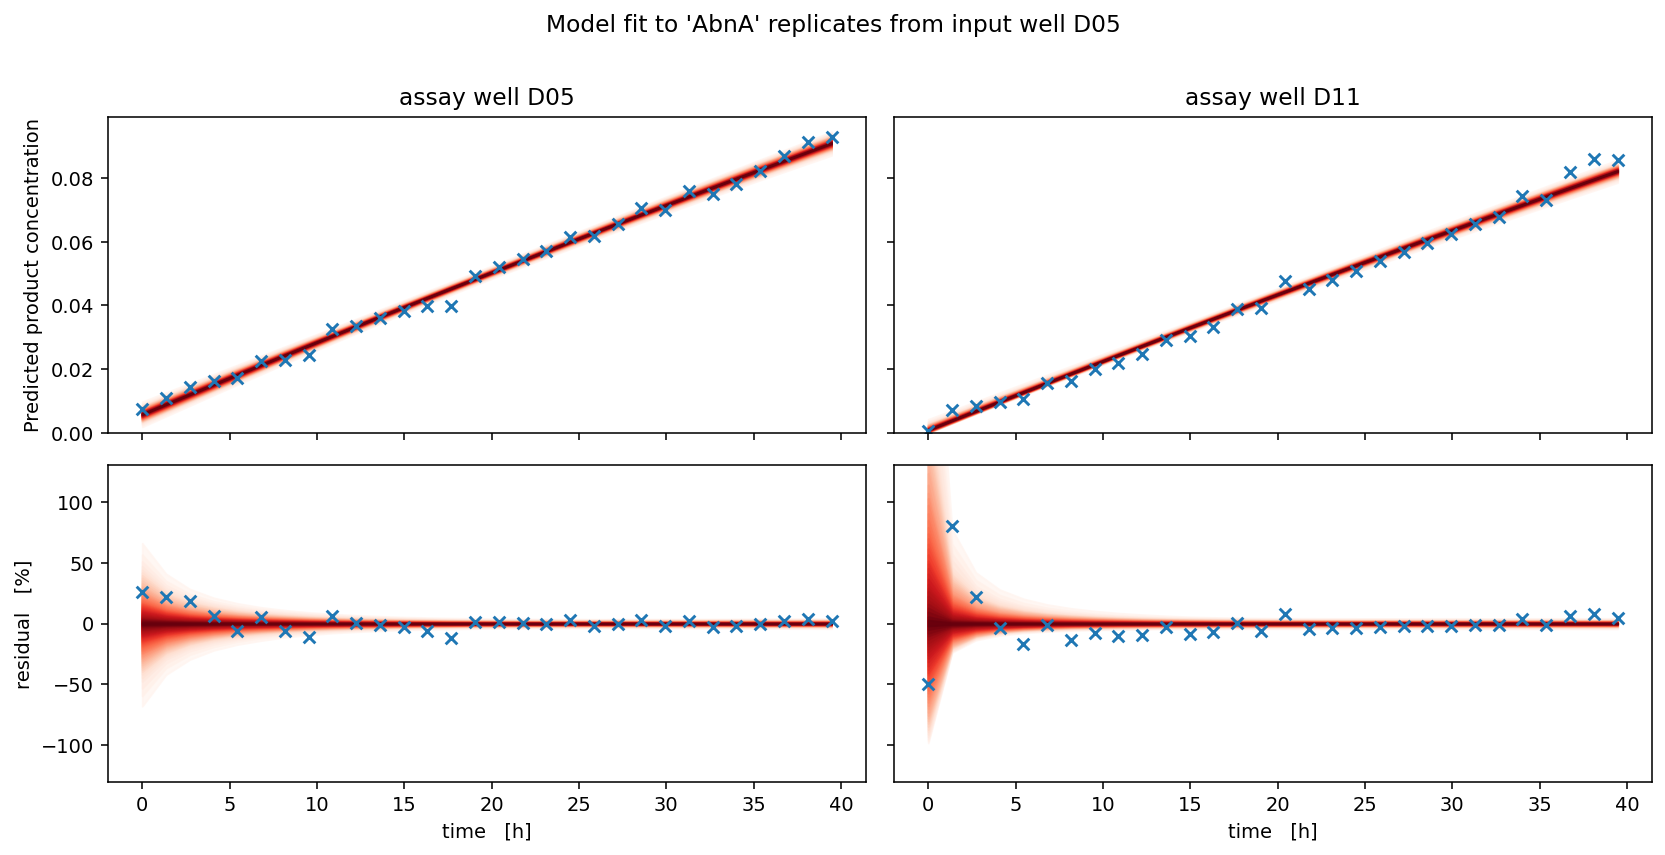

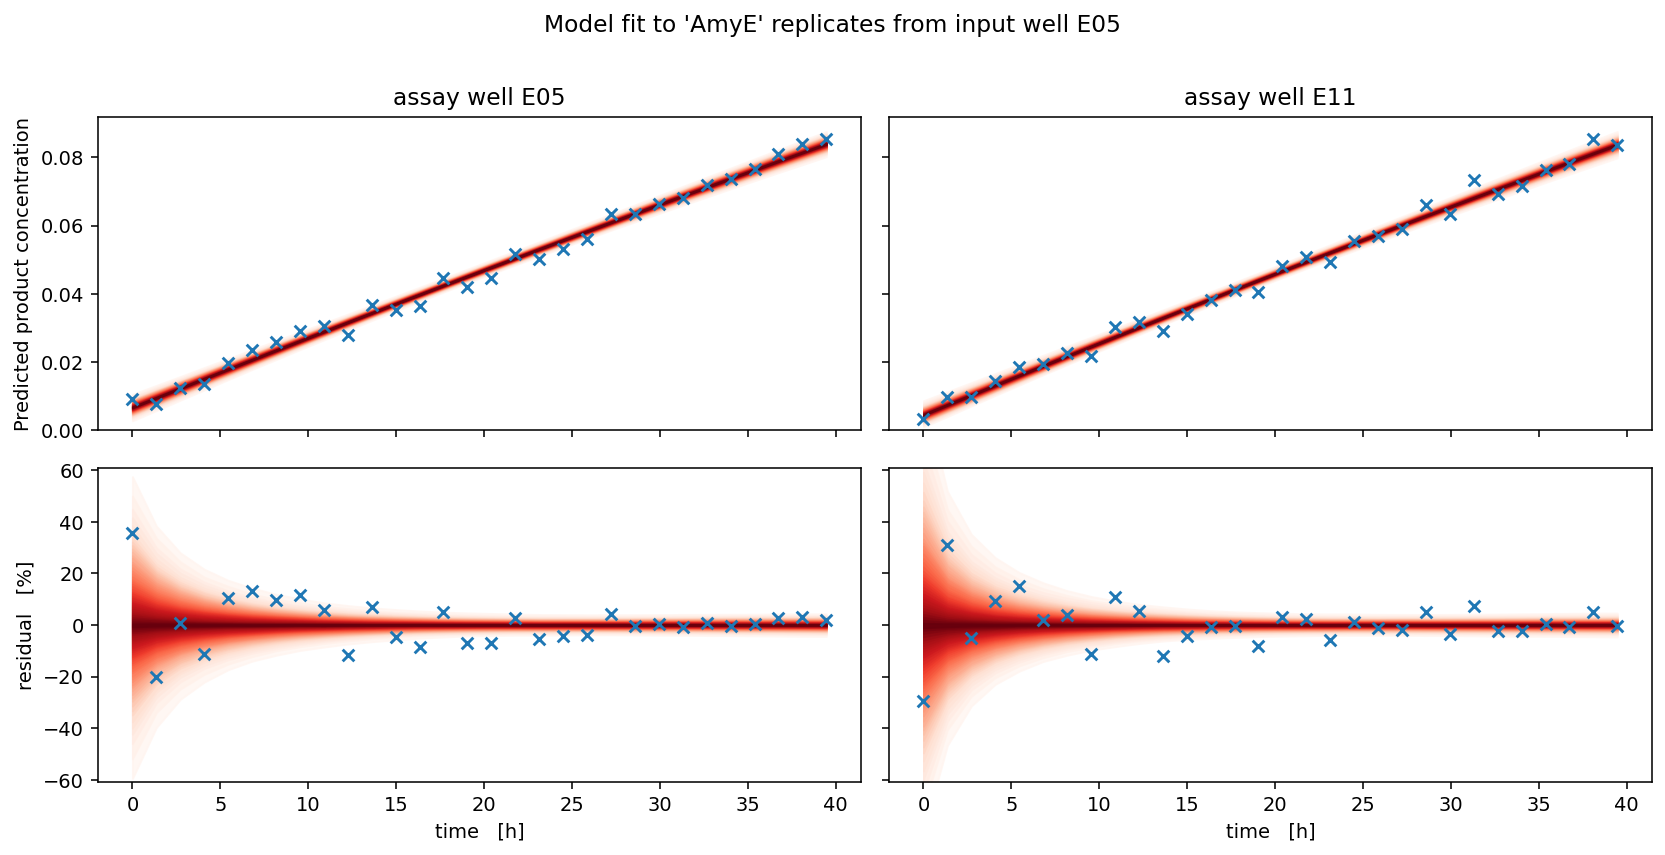

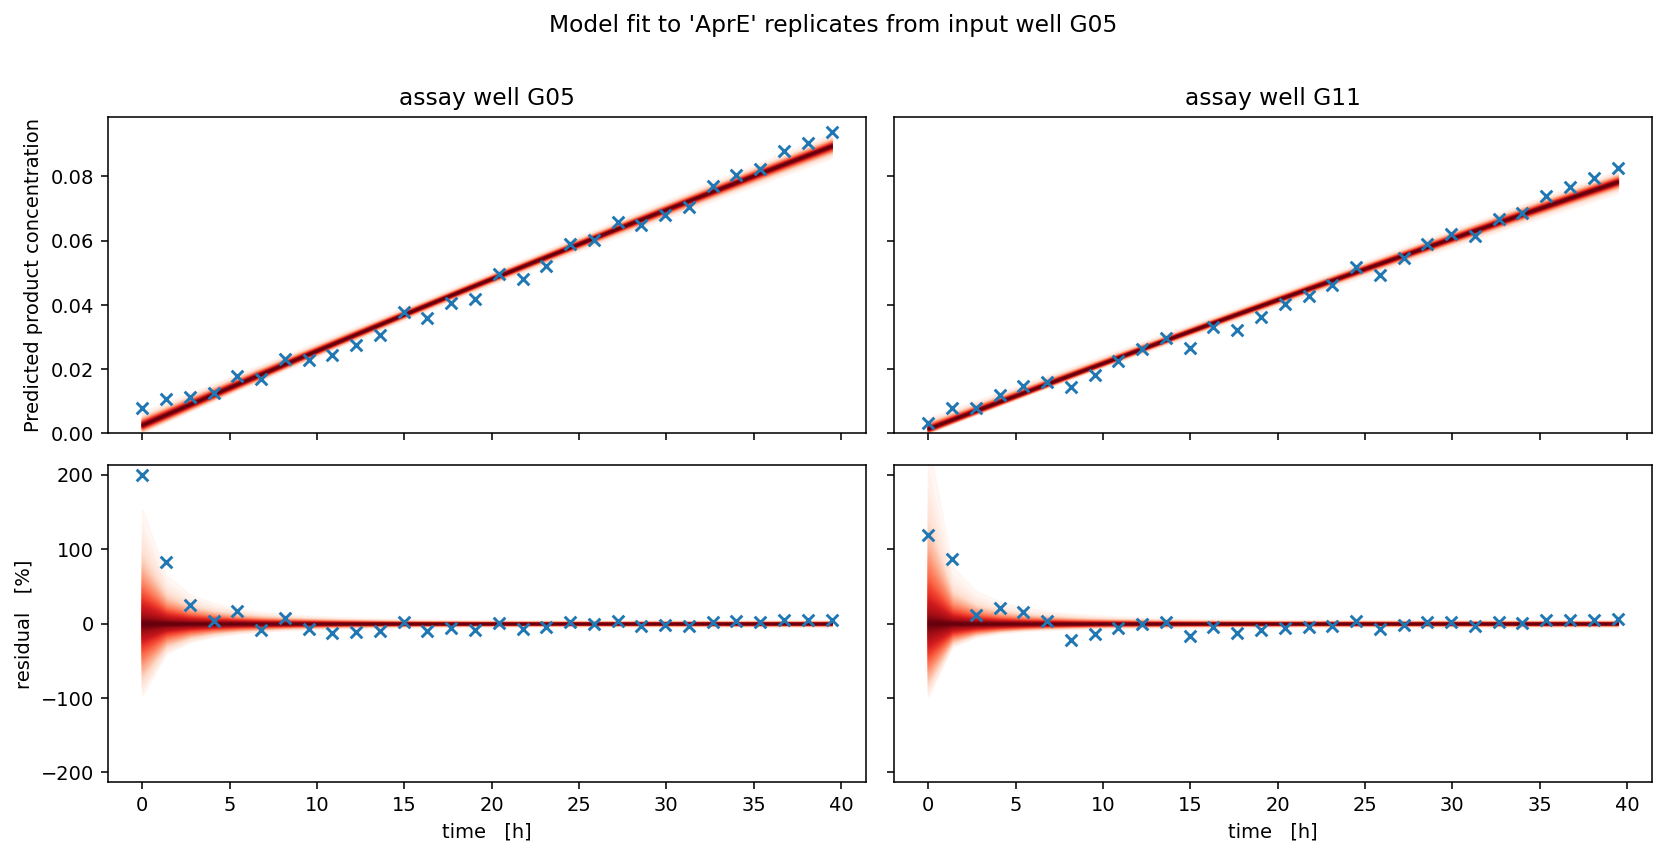

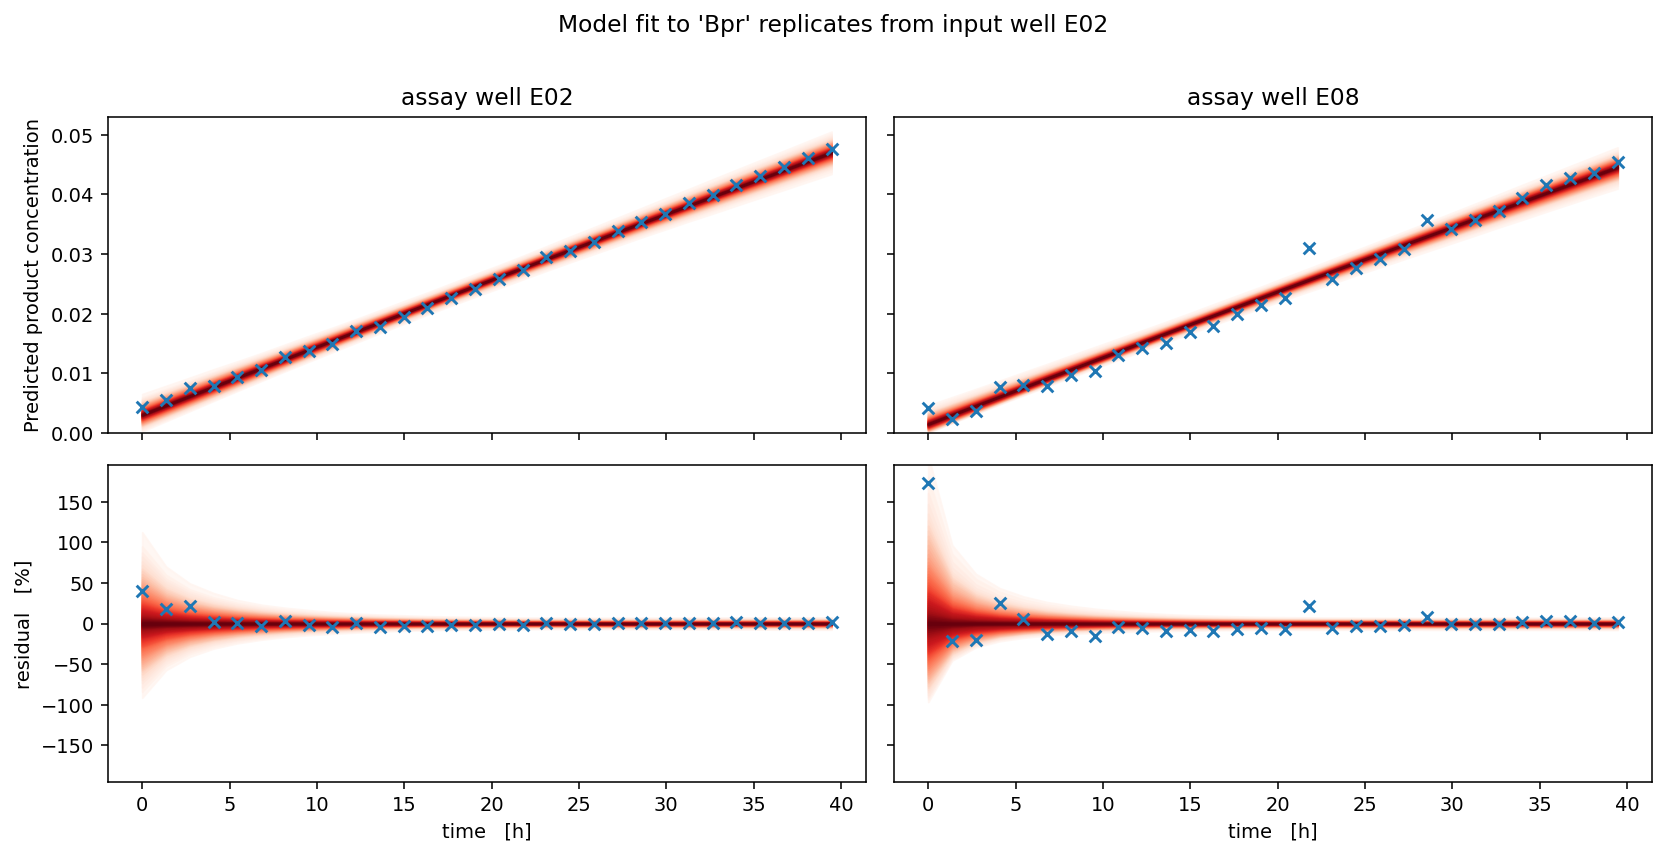

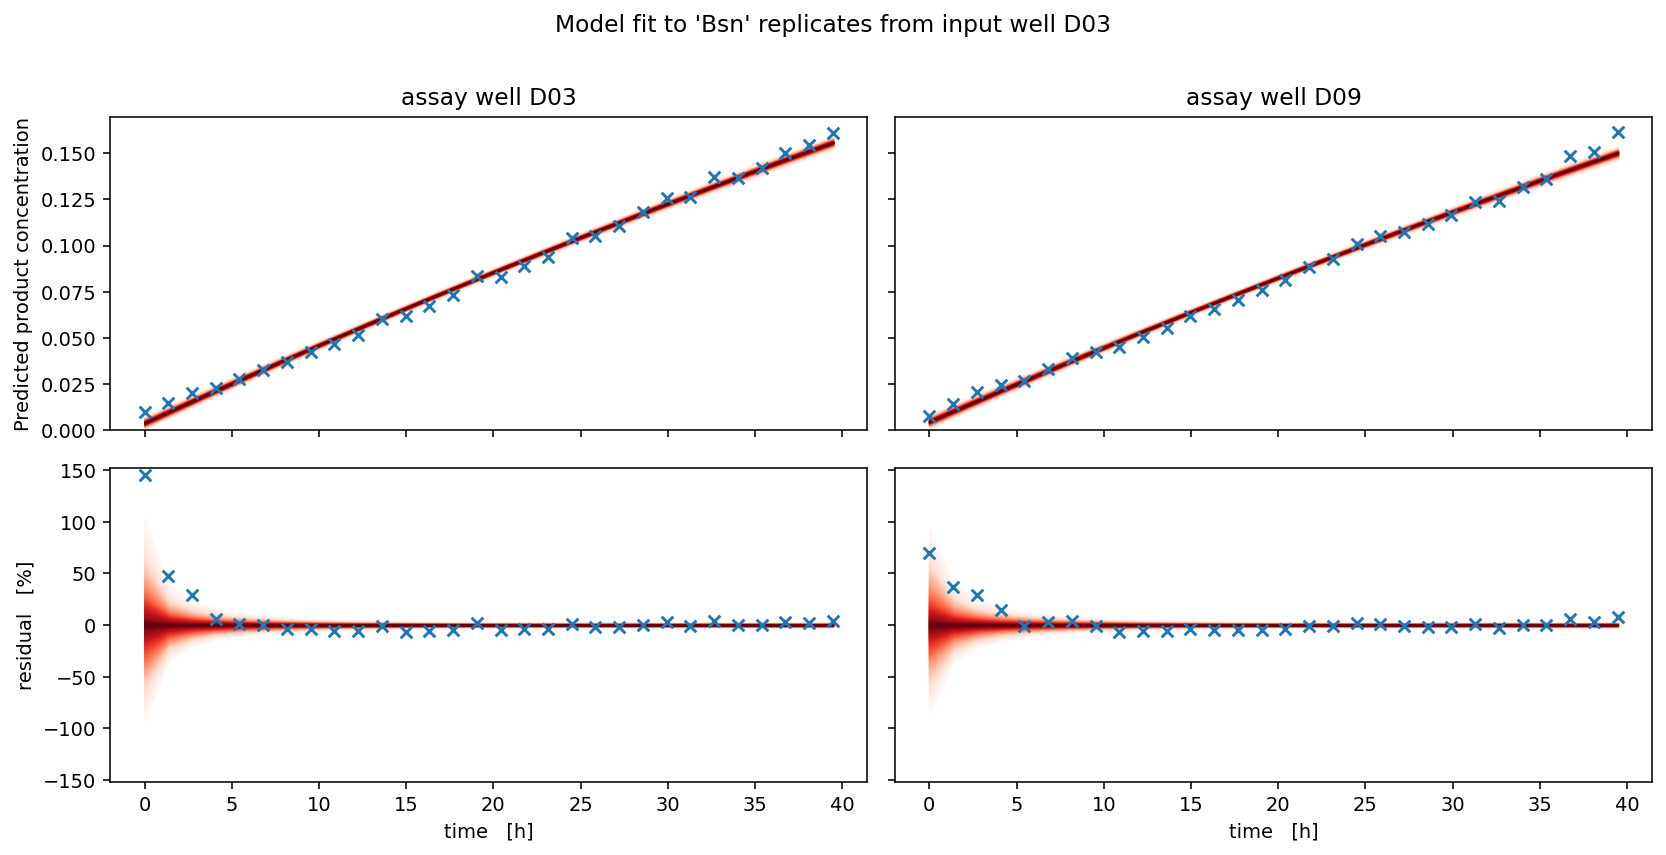

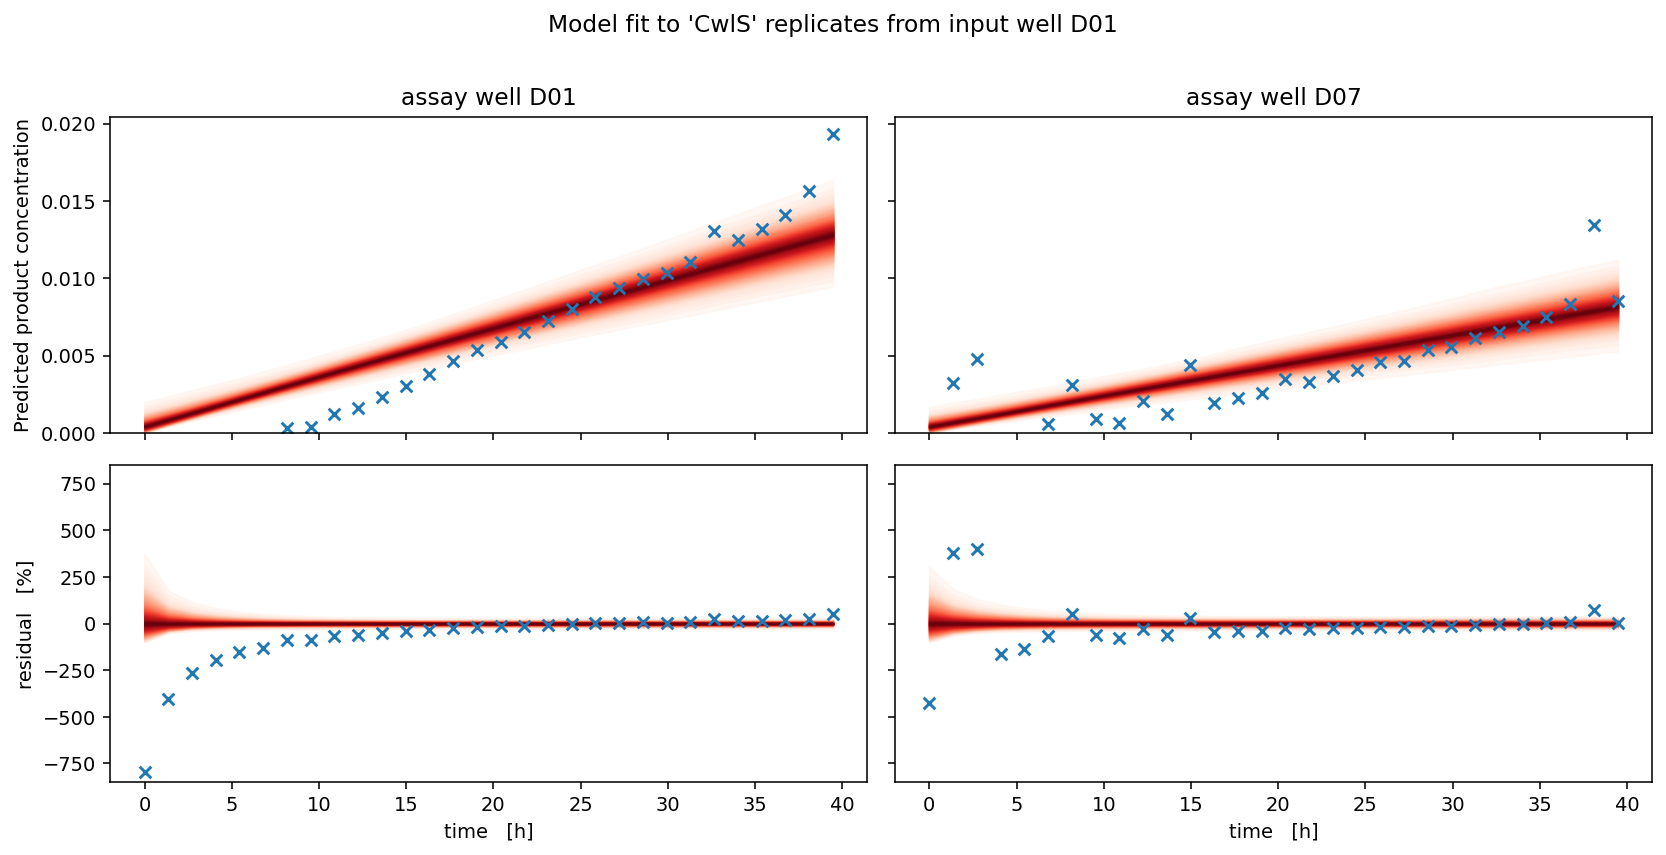

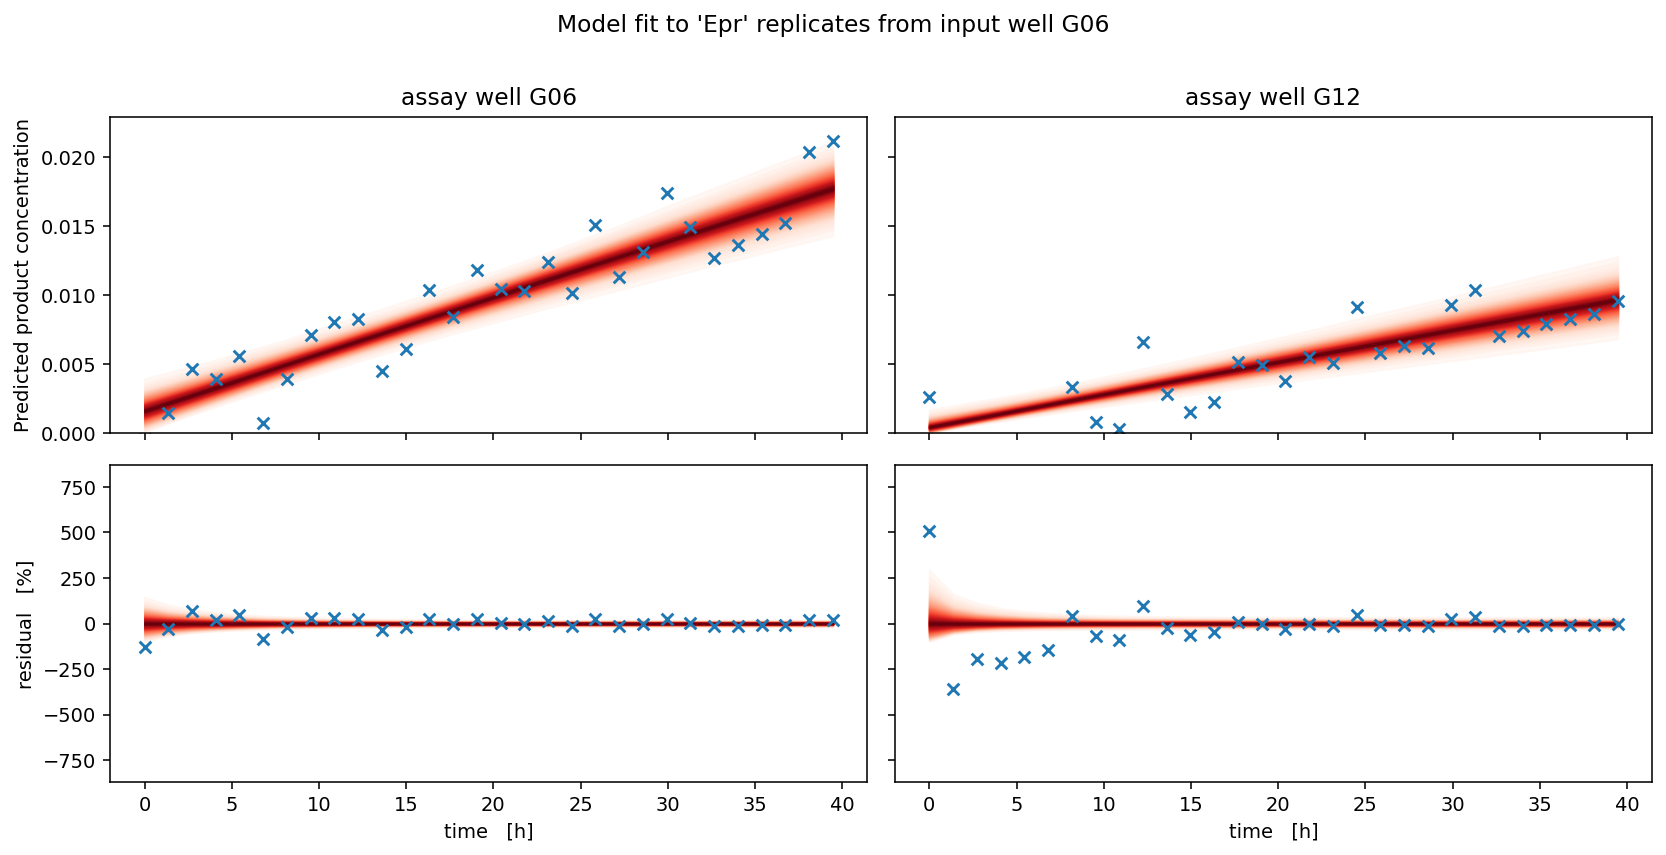

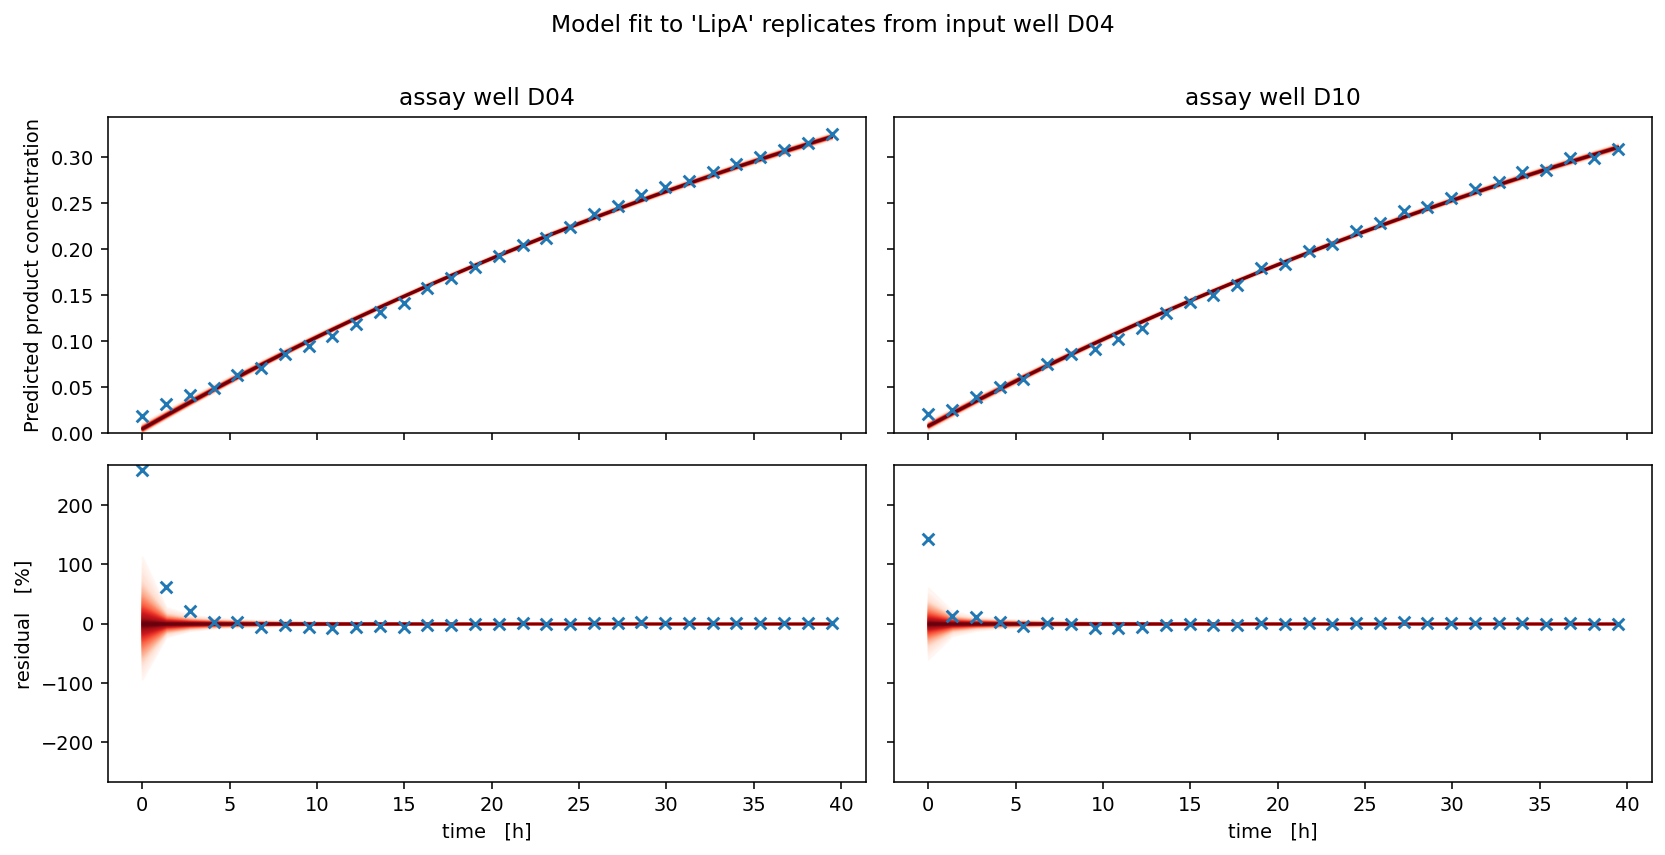

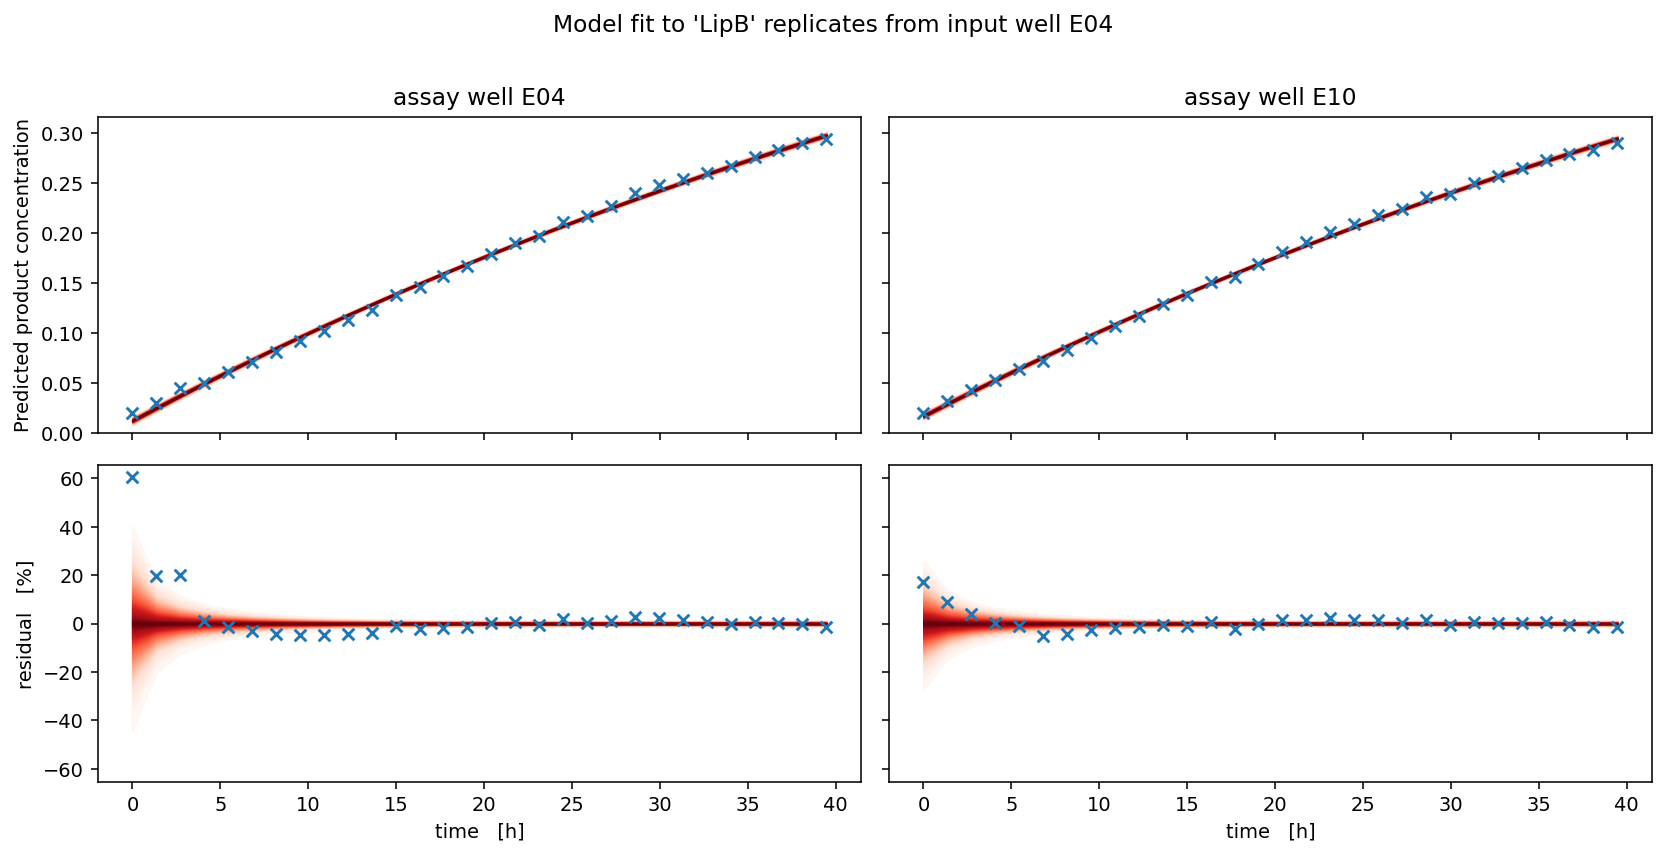

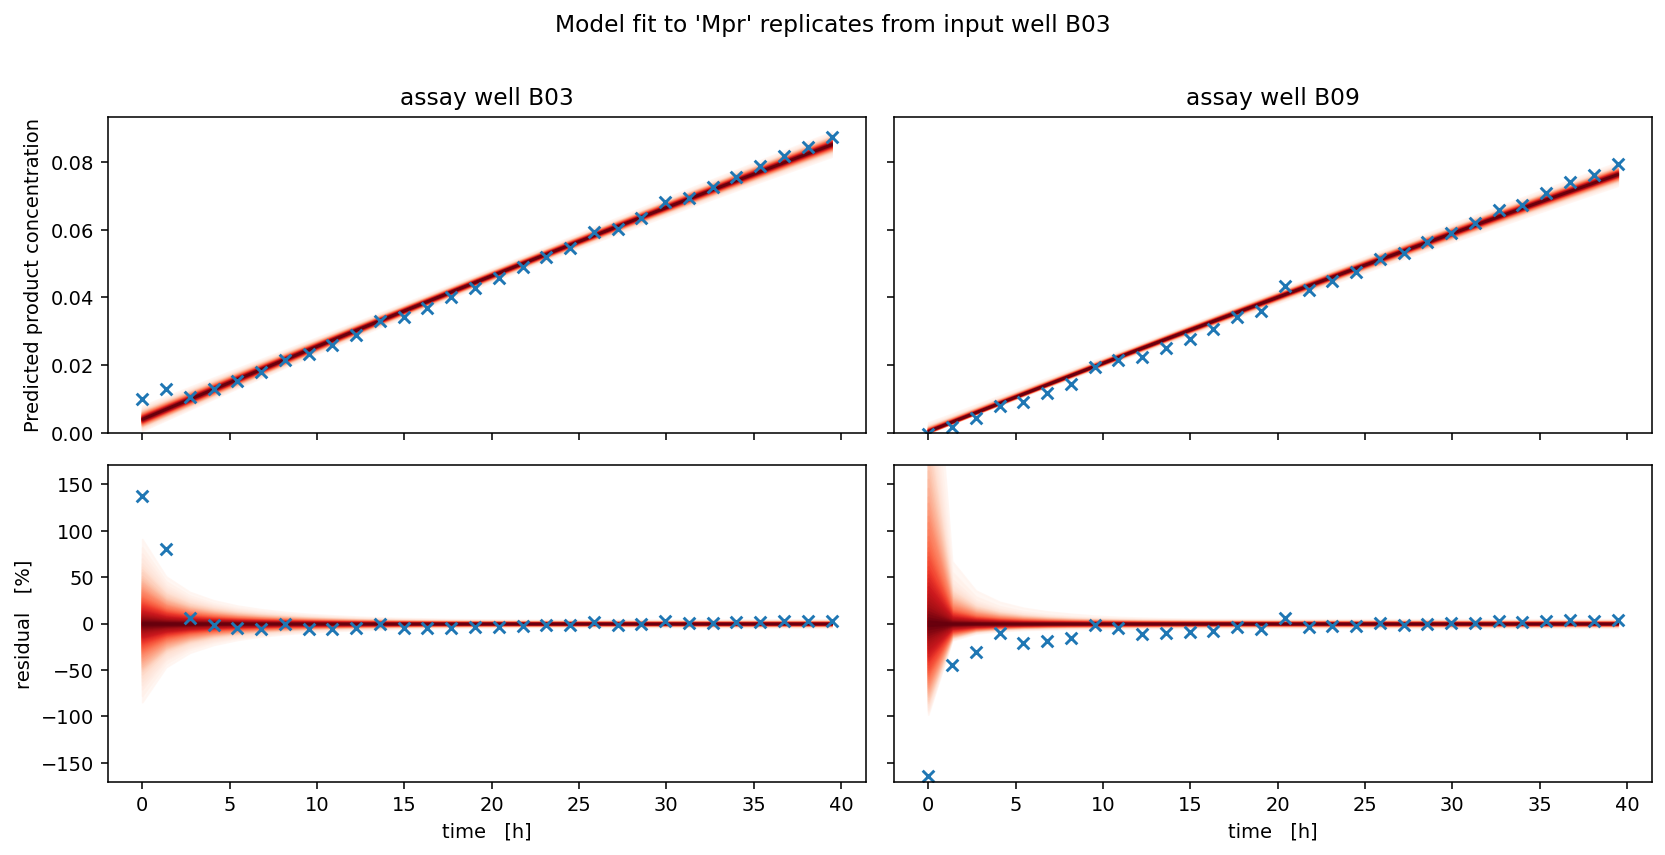

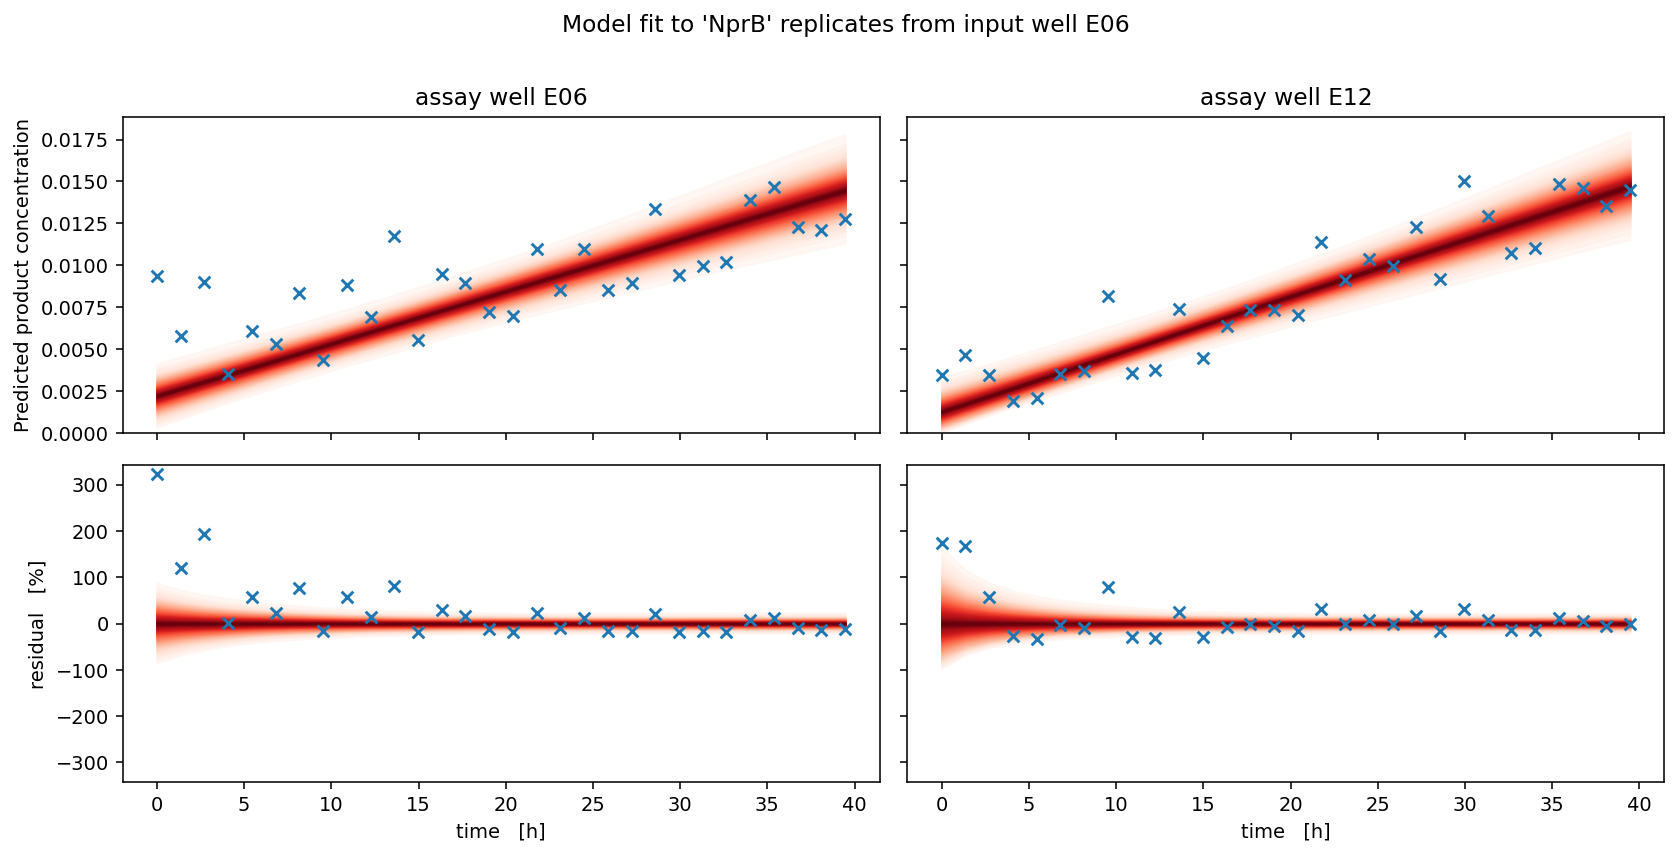

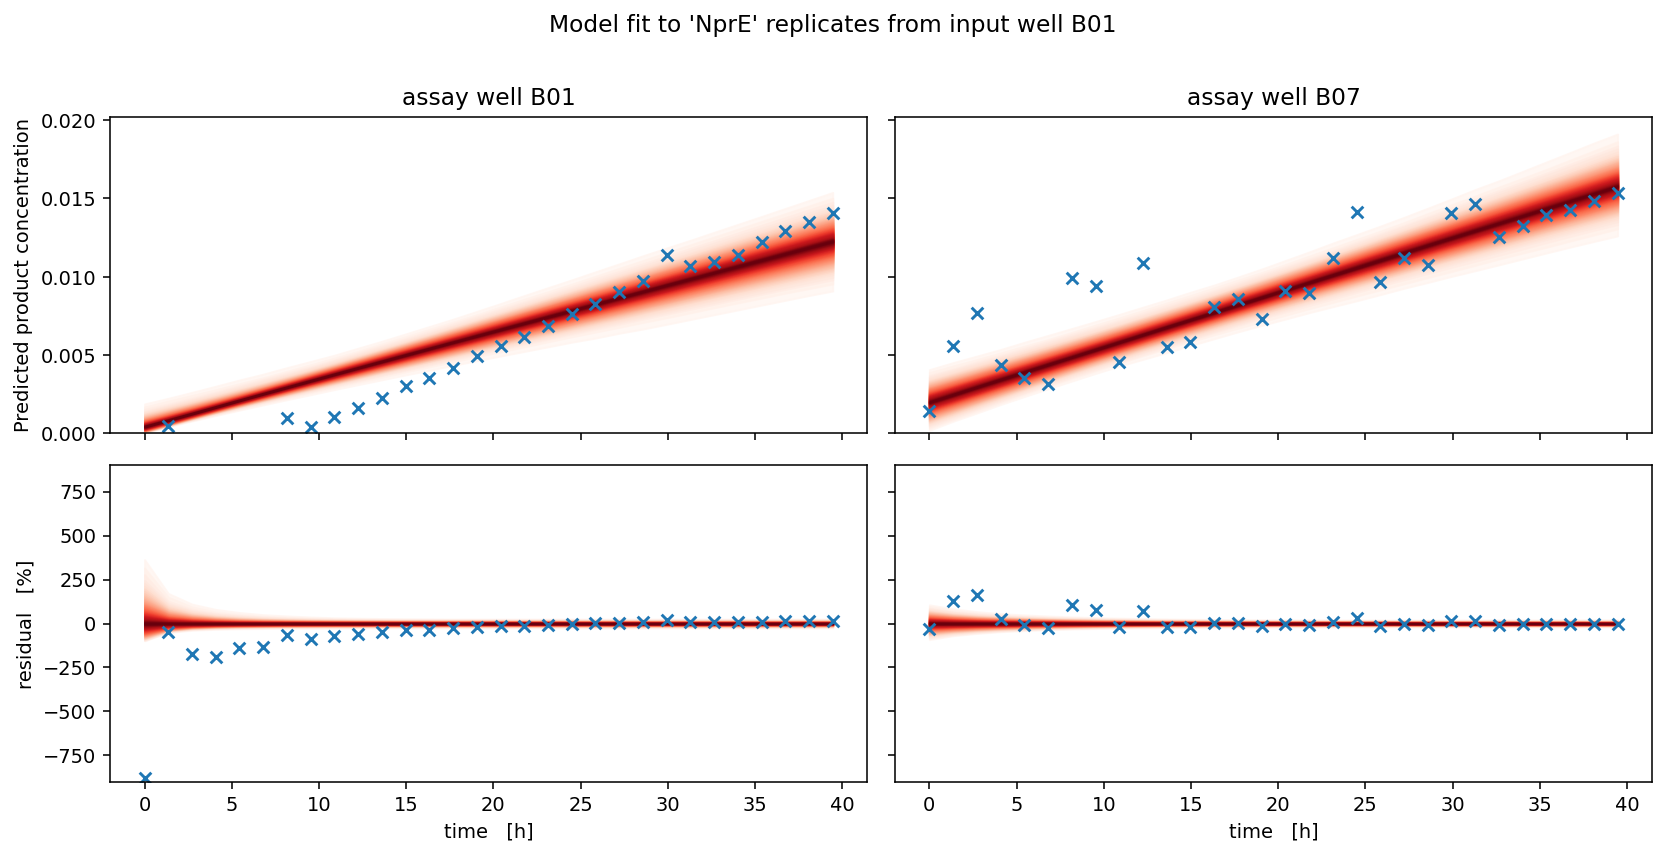

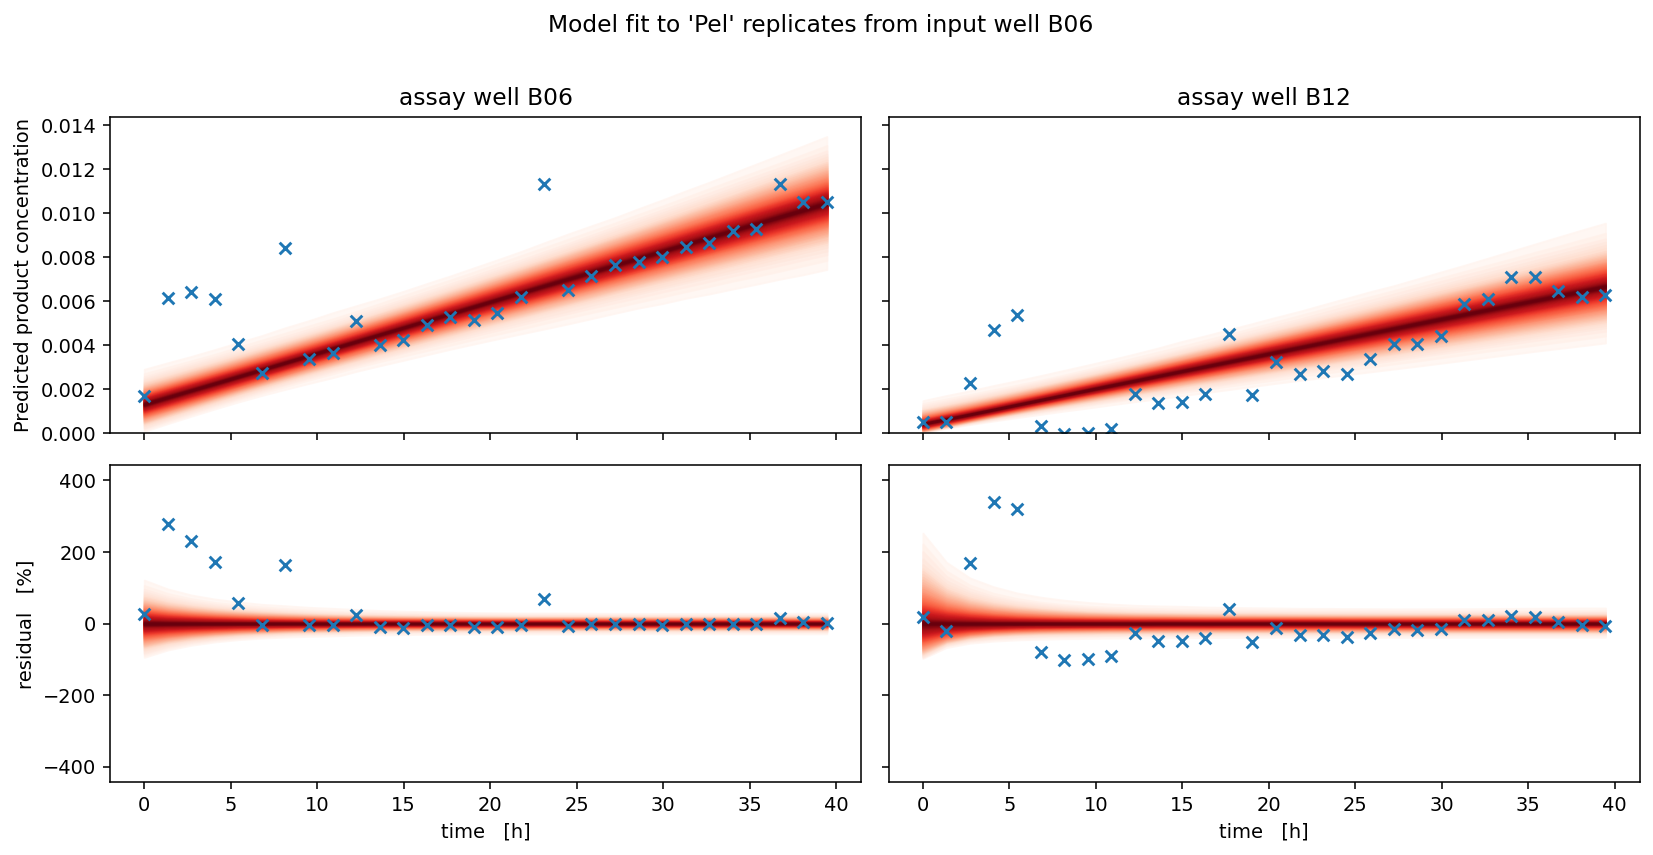

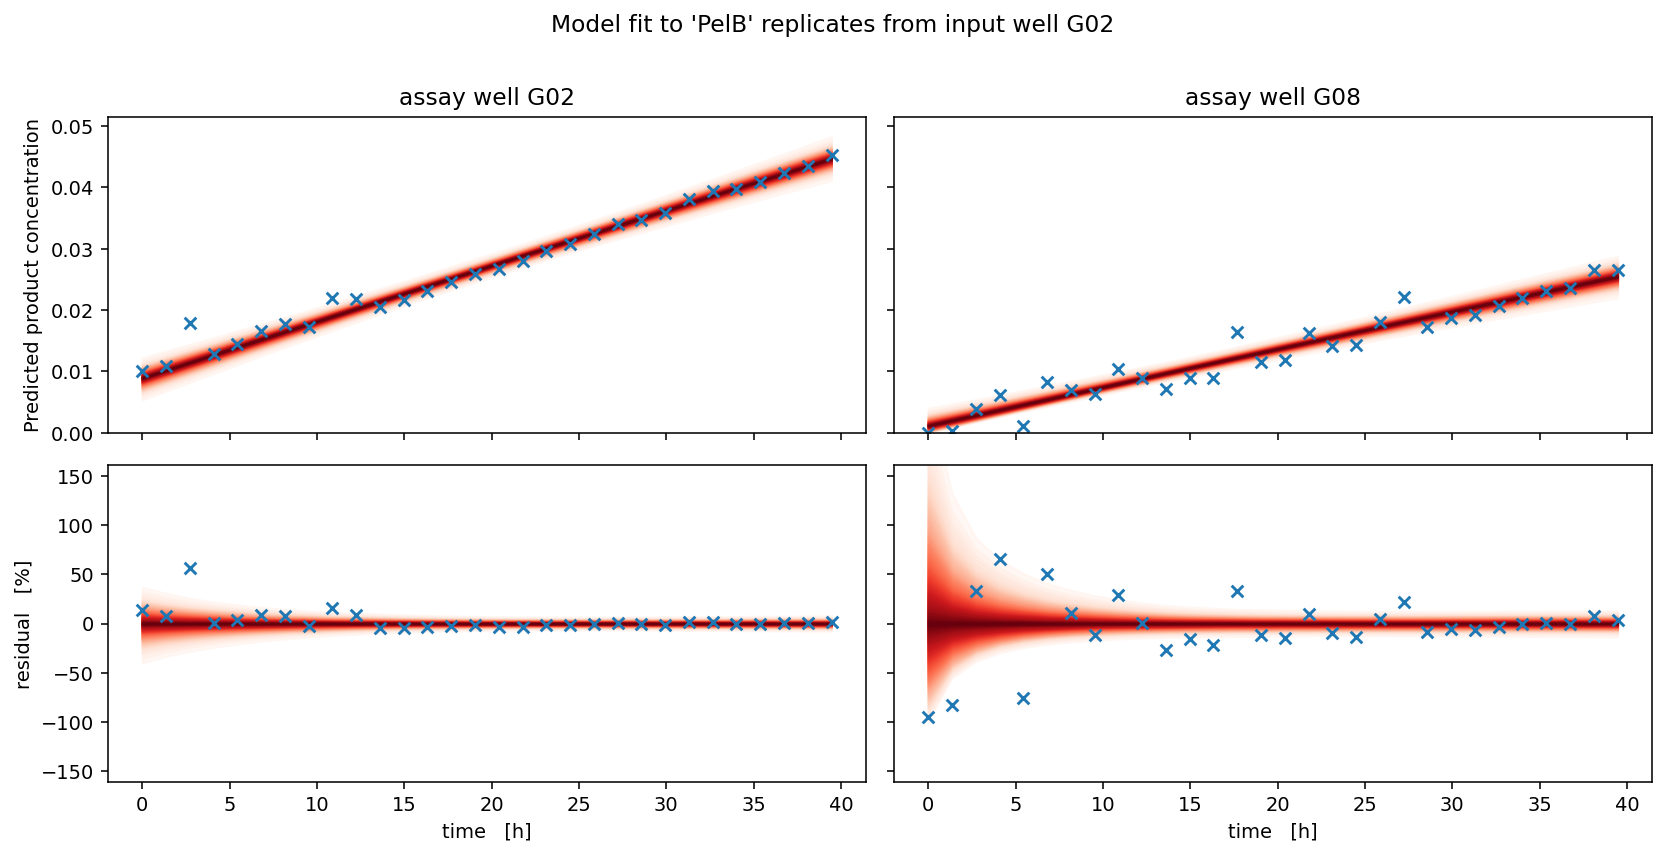

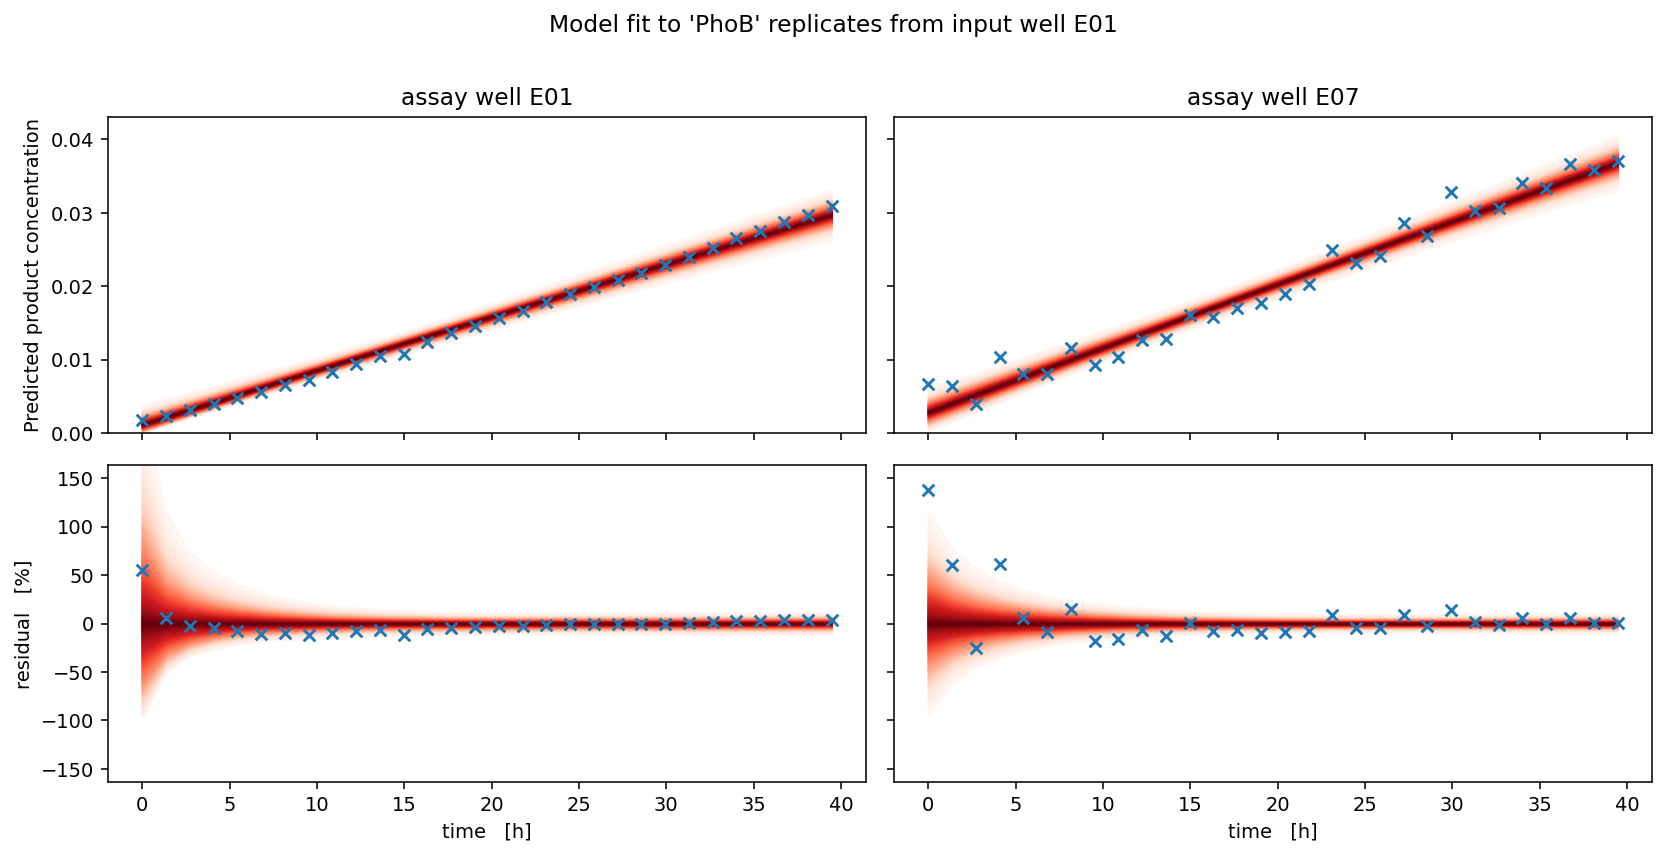

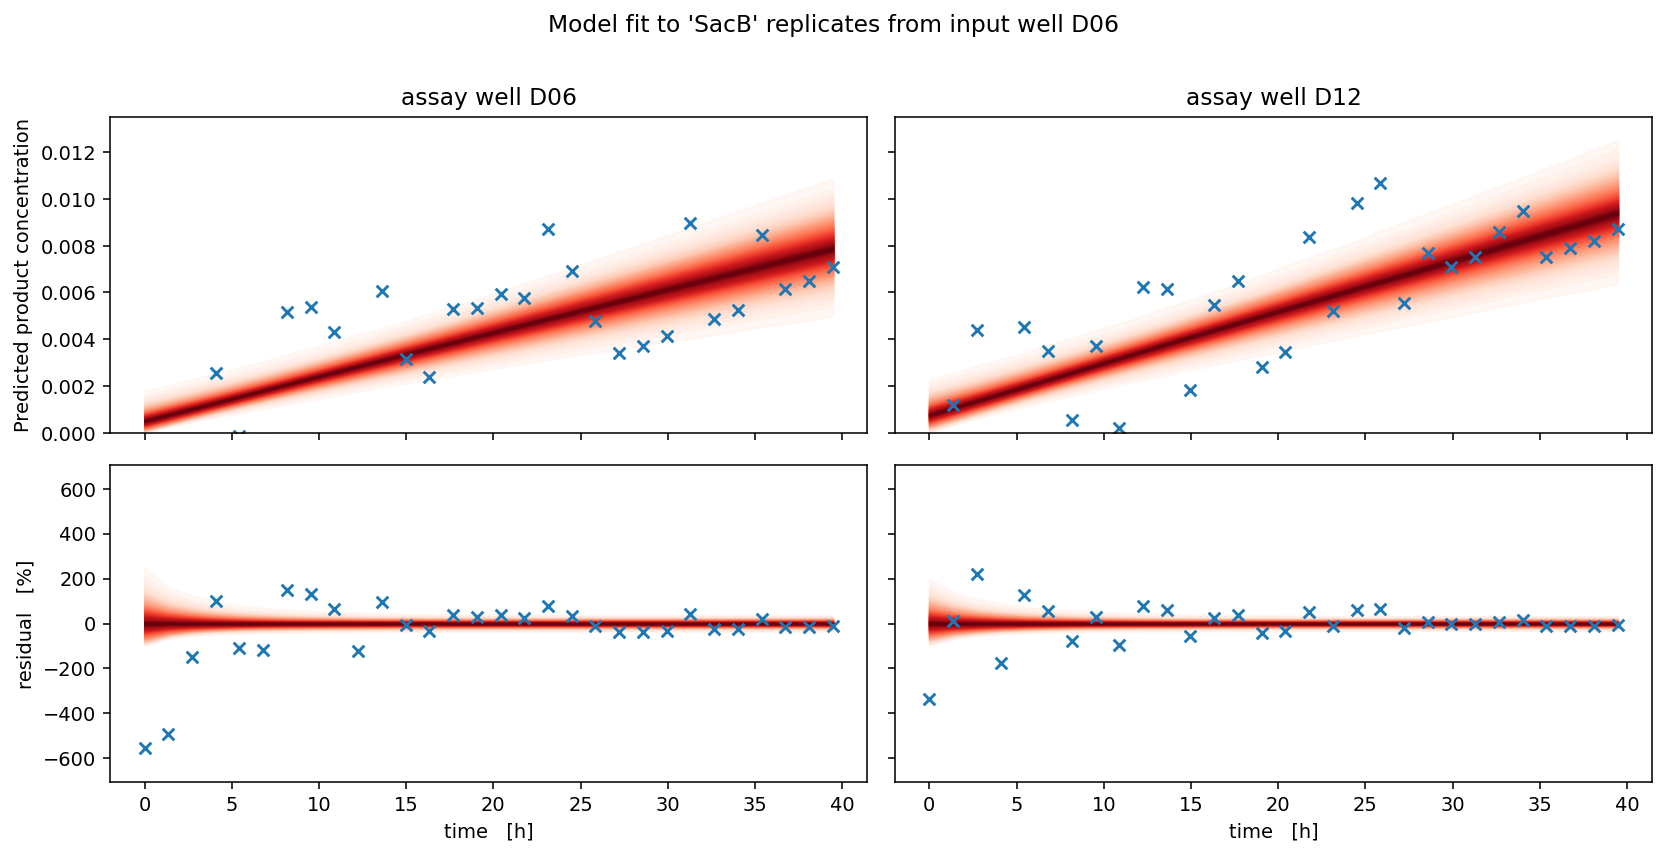

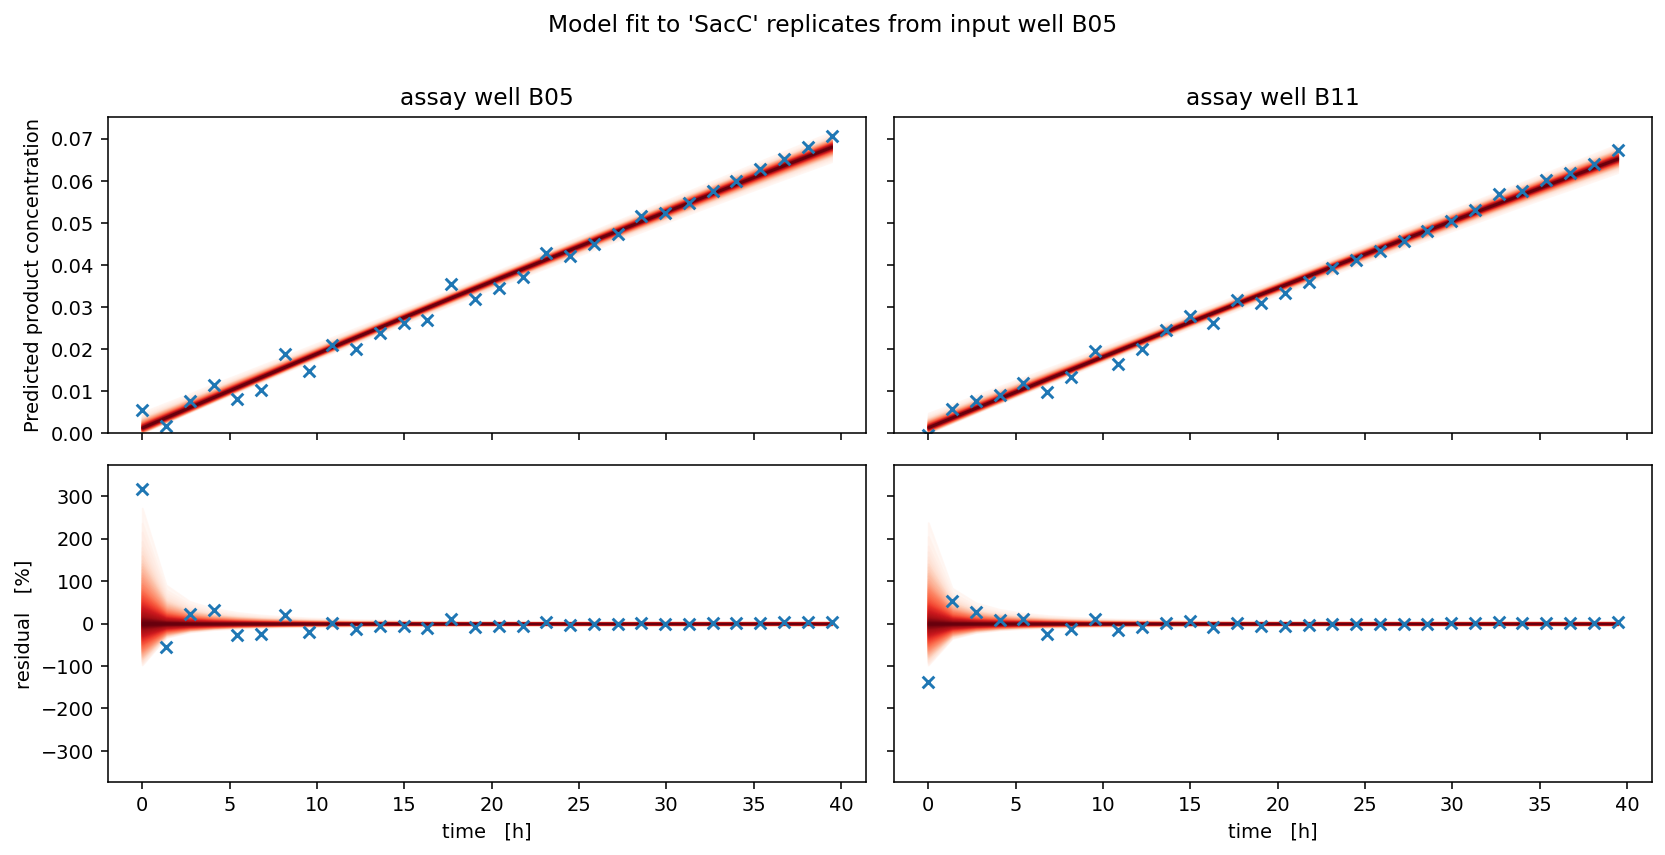

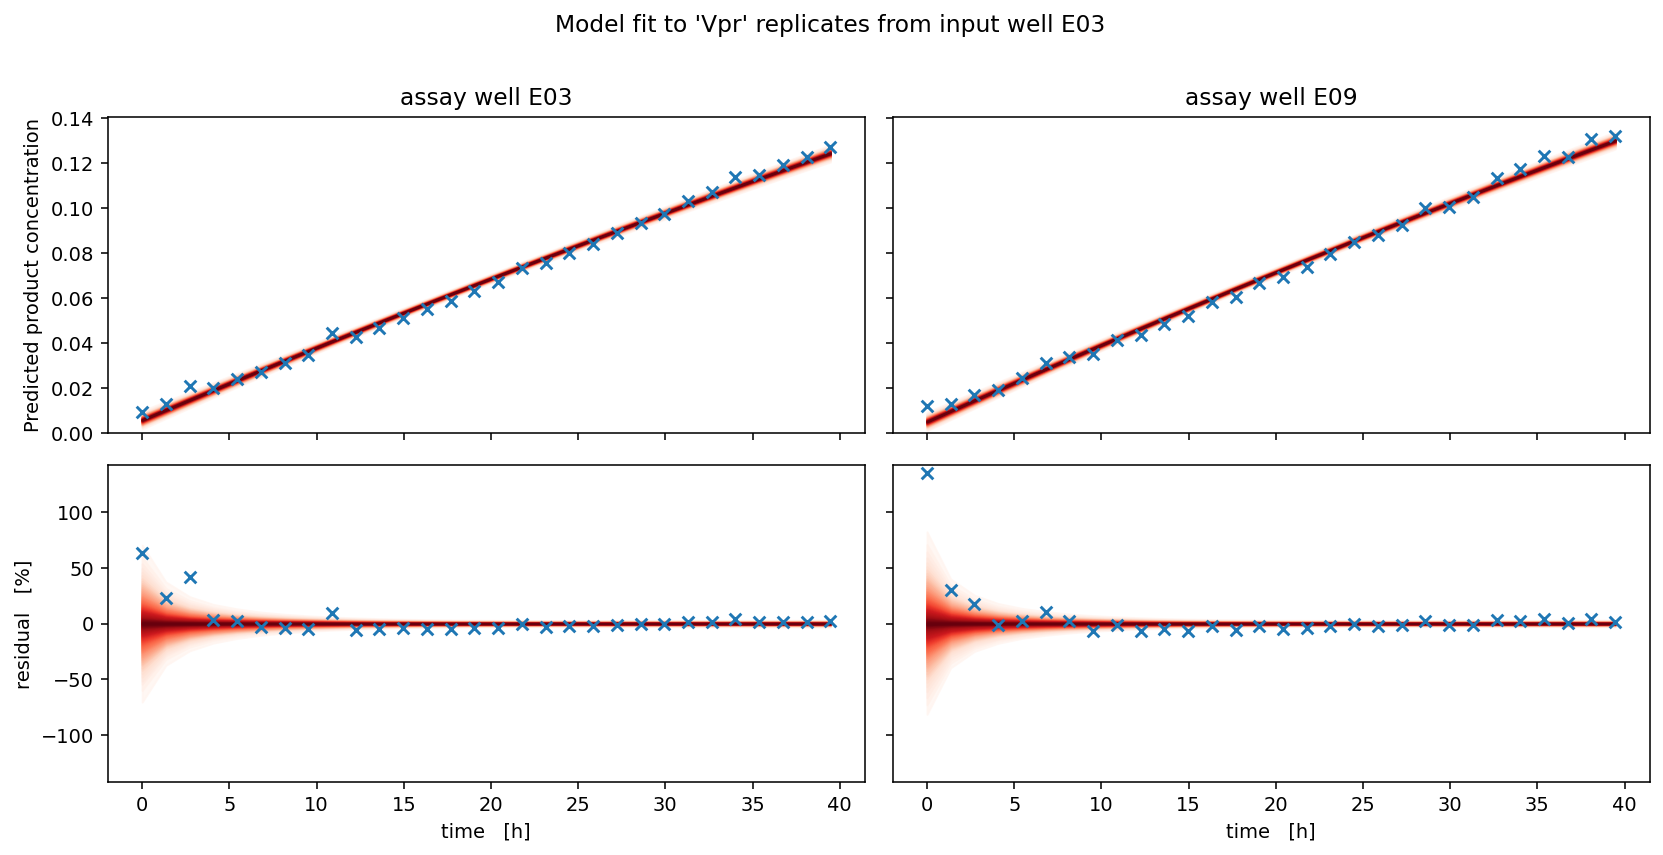

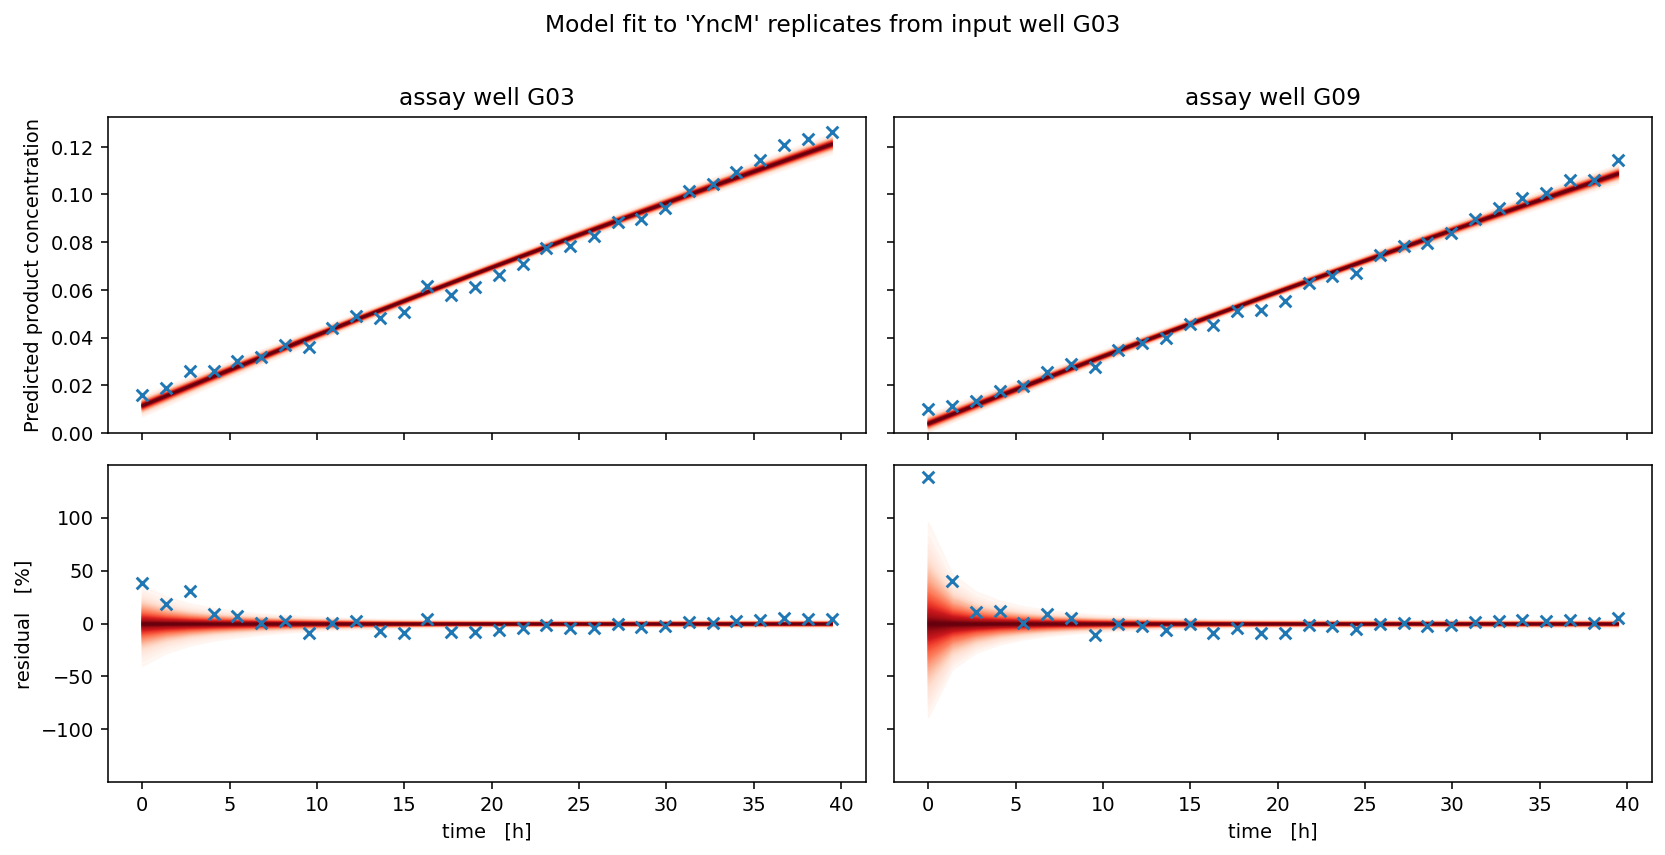

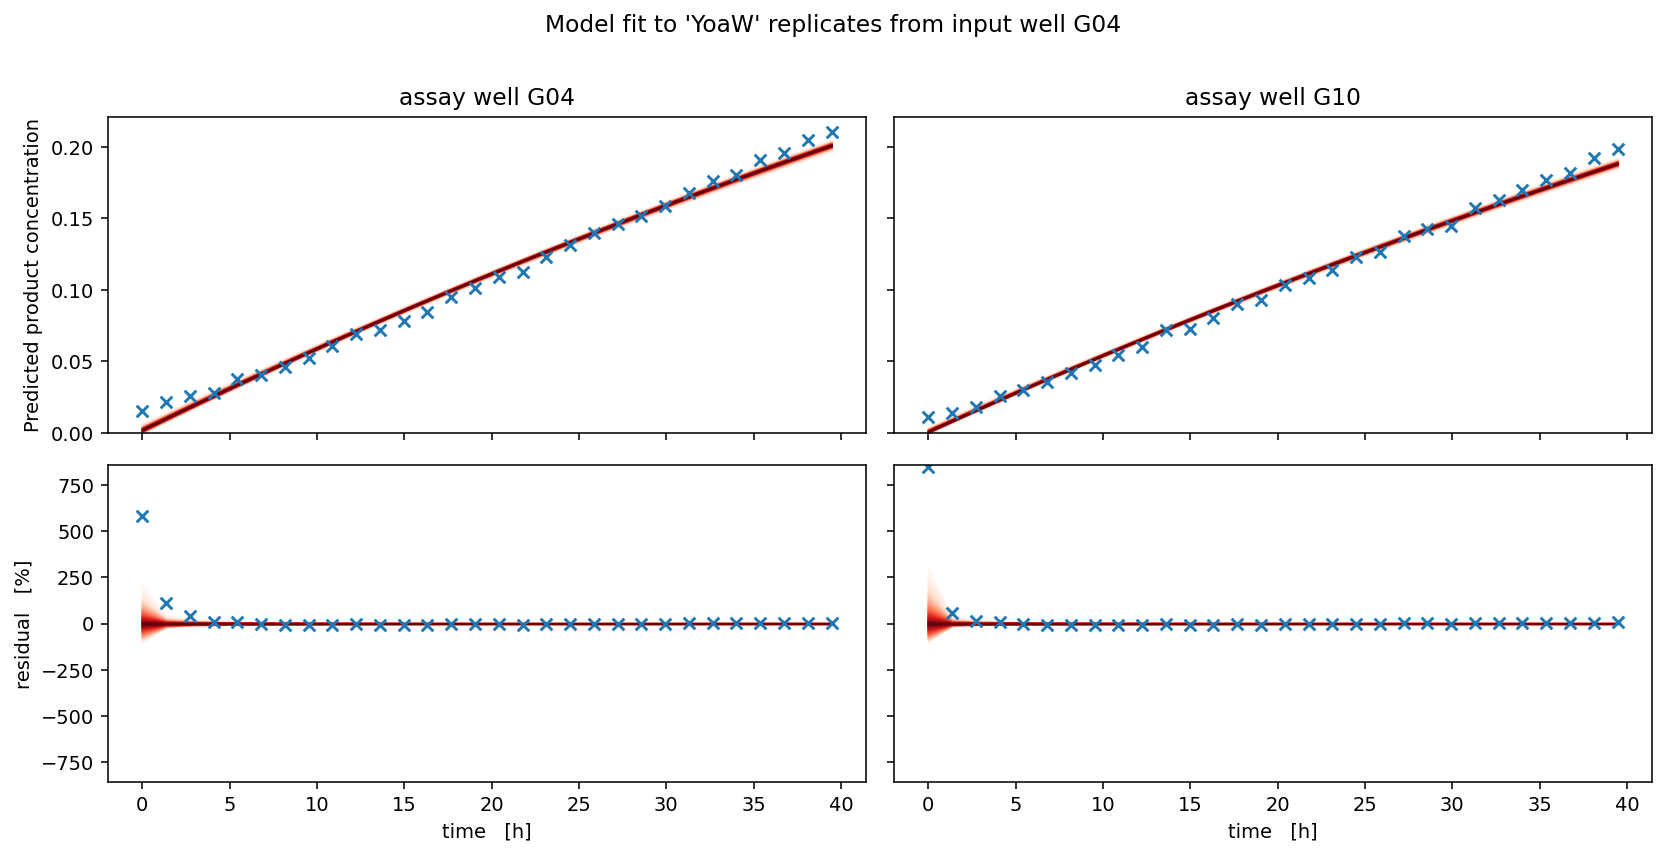

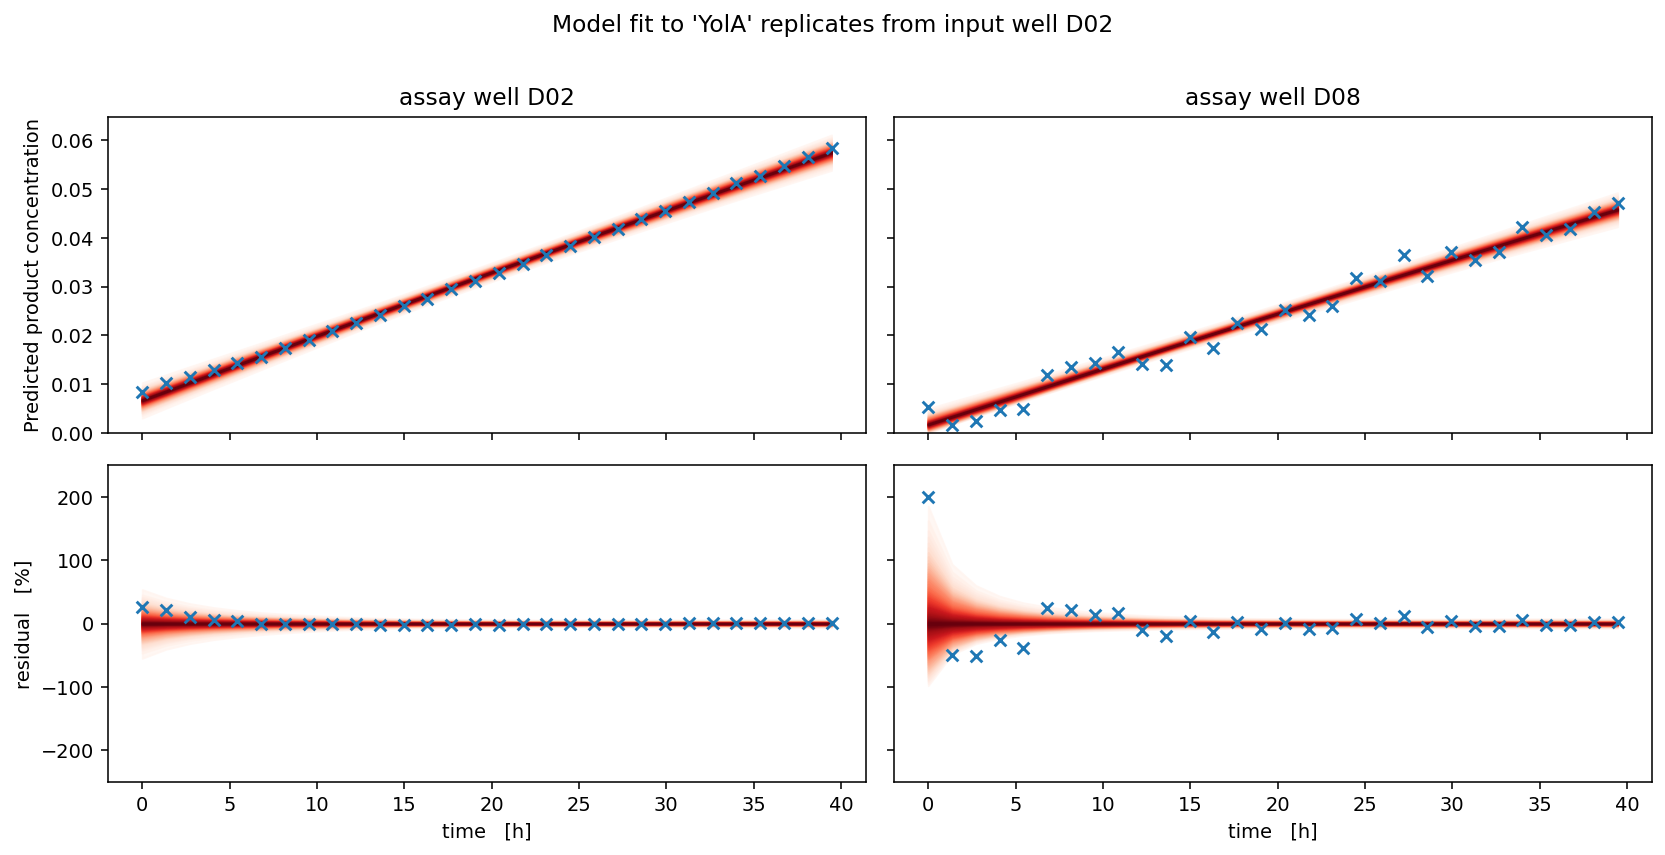

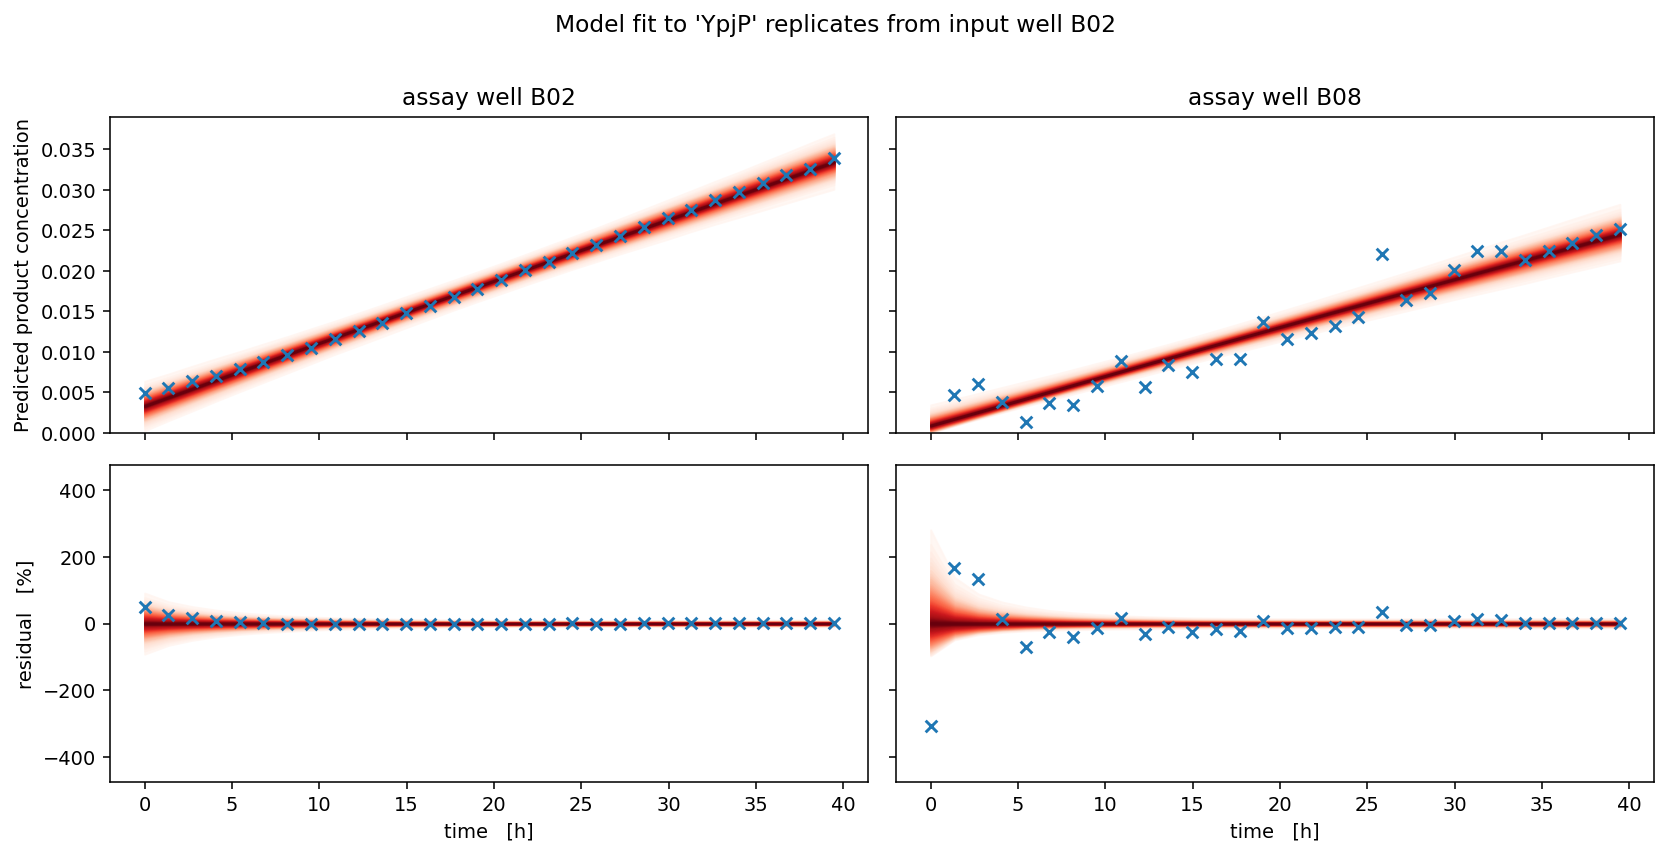

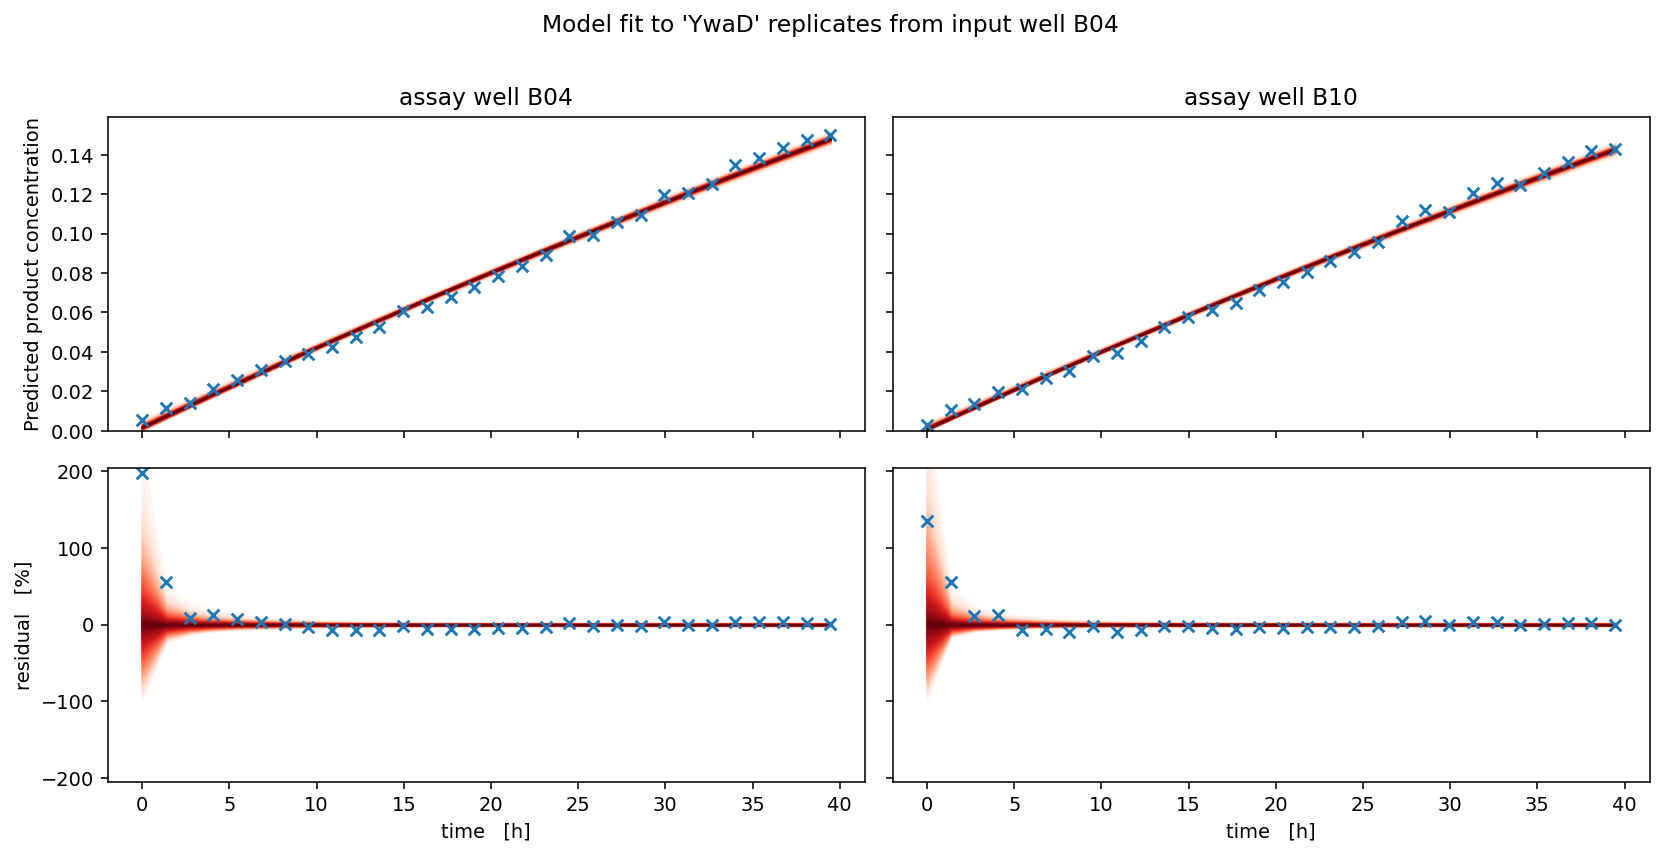

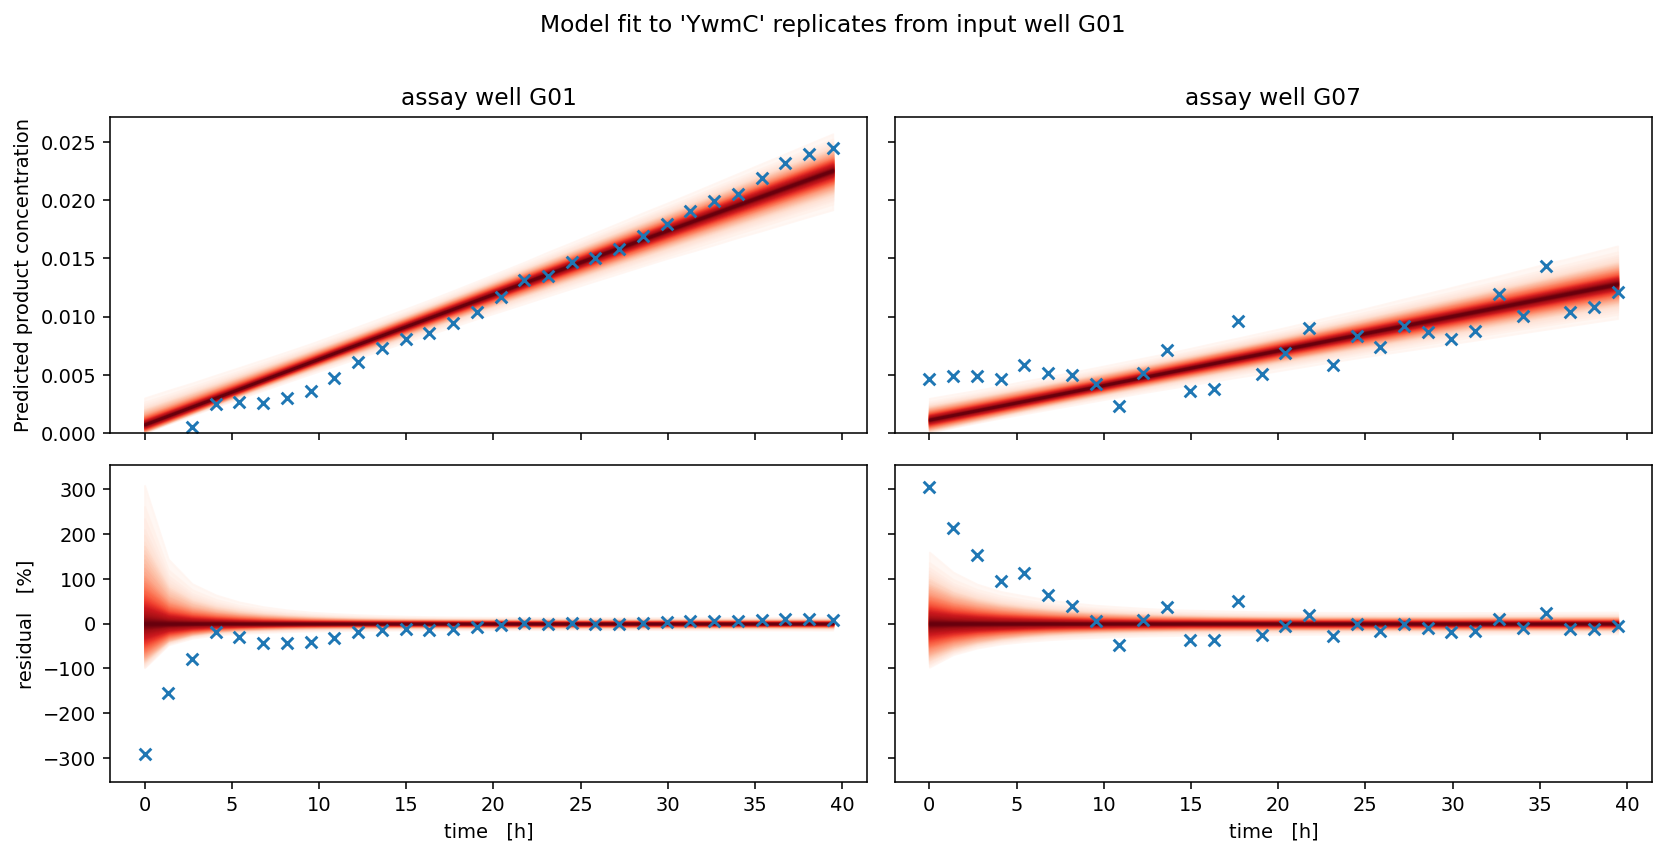

In [48]:
for sample_type in posterior.type.values:
    input_wells = df_inputs[df_inputs.type==sample_type].index.to_list()
    for input_well in input_wells:
        assay_wells = cutisplit.replicate_wells_from([input_well])
        k = posterior.k.sel(type=sample_type)
        cf_input = 1

        # figure constraints
        x_min = min(idata.constant_data.cutinase_time.values.flatten())
        x_max = max(idata.constant_data.cutinase_time.values.flatten())
        x_center = (x_min + x_max) / 2

        fig, axs = pyplot.subplots(
            dpi=140,
            figsize=(12, 6),
            nrows=2,
            ncols=2,
            sharey="row",
            sharex="col",
            squeeze=False,
        )

        residual_ptp = 0
        for c, assay_well in enumerate(assay_wells):
            k_input = k * cf_input
            k_assay = posterior.k_assay.sel(assay_well=assay_well)


            # and the actual product concentration
            pymc3.gp.util.plot_gp_dist(
                ax=axs[0, c],
                samples=posterior.product_concentration.sel(
                    assay_well=assay_well
                ).values.T,
                x=idata.constant_data.cutinase_time[0,:].values,
                samples_alpha=0,
            )
            axs[0, c].scatter(
                idata.constant_data.cutinase_time.values[0,:],
                cm_nitrophenol.predict_independent(
                    idata.constant_data.cutinase_absorbance.sel(assay_well=assay_well)
                ),
                marker="x",
            )

            # residuals for the product concentration
            samples = posterior.product_concentration.sel(assay_well=assay_well)
            median = samples.median("sample").values.T
            data = cm_nitrophenol.predict_independent(idata.constant_data.cutinase_absorbance.sel(assay_well=assay_well))
            rel_residuals = ((data - median) / median * 100).values
            residual_ptp = max(residual_ptp, numpy.ptp(rel_residuals))

            pymc3.gp.util.plot_gp_dist(
                ax=axs[1, c],
                samples=(samples.values.T - median) / median * 100,
                x=idata.constant_data.cutinase_time.values[0,:],
                samples_alpha=0,
            )
            axs[1, c].scatter(
                idata.constant_data.cutinase_time.values[0,:], rel_residuals, marker="x"
            )

            # formatting
            axs[0, c].set_title(f"assay well {assay_well}")
            axs[1, c].set_xlabel("time   [h]")
        axs[0, 0].set_ylim(0)
        axs[0, 0].set_ylabel(
            "Predicted product concentration"
        )
        axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
        axs[1, 0].set_ylabel("residual   [%]")
        fig.suptitle(
            f"Model fit to '{sample_type}' replicates from input well {input_well}", y=1.01
        )
        fig.tight_layout()